# Projekt 1 - Analiza ryzyka kredytowego
## Pipeline preprocessing dla modeli interpretowalnych

**Cel:** Przygotowanie danych pod interpretowalny model predykcyjny z możliwością odwrócenia transformacji

**Kluczowe cechy:**
- ✅ Tylko transformacje odwracalne (Box-Cox, Yeo-Johnson, log1p)
- ✅ Brak transformacji kwantylowych niszczących interpretowalność
- ✅ Możliwość inverse_transform dla każdej cechy
- ✅ Gotowe do analizy SHAP/LIME

### Import wszystkich bibliotek

In [211]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

# Scipy
from scipy.stats import shapiro, chi2_contingency
from scipy.stats.mstats import winsorize

# Scikit-learn - preprocessing i model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Scikit-learn - modele
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Scikit-learn - metryki
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.feature_selection import chi2

# Modele interpretowalne zaawansowane
try:
    from interpret.glassbox import ExplainableBoostingClassifier
    EBM_AVAILABLE = True
except ImportError:
    print("⚠️  interpret not installed. Install: pip install interpret")
    EBM_AVAILABLE = False

try:
    from pygam import LogisticGAM, s
    GAM_AVAILABLE = True
except ImportError:
    print("⚠️  pygam not installed. Install: pip install pygam")
    GAM_AVAILABLE = False

try:
    import wittgenstein as lw
    RIPPER_AVAILABLE = True
except ImportError:
    print("⚠️  wittgenstein not installed. Install: pip install wittgenstein")
    RIPPER_AVAILABLE = False

# Konfiguracja pandas i matplotlib
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')

print("✅ Wszystkie biblioteki załadowane")
print(f"   • EBM dostępny: {EBM_AVAILABLE}")
print(f"   • GAM dostępny: {GAM_AVAILABLE}")
print(f"   • RIPPER dostępny: {RIPPER_AVAILABLE}")

✅ Wszystkie biblioteki załadowane
   • EBM dostępny: True
   • GAM dostępny: True
   • RIPPER dostępny: True


### Wczytanie danych

In [212]:
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary danych: {df.shape}")
print(f"Procent klasy pozytywnej (default=1): {100*df['default'].sum()/len(df):.2f}%")

Wymiary danych: (3000, 220)
Procent klasy pozytywnej (default=1): 6.10%


### Podział na zbiór treningowy i testowy

In [213]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]

print(f"Zbiór treningowy: {X_train.shape}")
print(f"Zbiór testowy: {X_test.shape}")

Zbiór treningowy: (2100, 219)
Zbiór testowy: (900, 219)


## Funkcje Pomocnicze

Funkcje do identyfikacji kolumn i obliczania limitów winsoryzacji.

In [214]:
def identify_columns_to_drop(X, y=None, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia:
    - kolumny z brakami danych
    - kolumny kategoryczne (typu object)
    - kolumny z małą liczbą unikalnych wartości (<=2)
    - kolumny ze stałą wartością
    
    Opcjonalnie: kolumny z >90% zer można zachować jako binarne (zamiast usuwać)
    
    Parametry:
    ----------
    X : pd.DataFrame
        Dane wejściowe
    y : pd.Series, optional
        Zmienna docelowa
    missing_threshold : float
        Próg braków danych
    zero_threshold : float
        Próg % zer (domyślnie 0.90 = 90%)
    keep_sparse_as_binary : bool
        Jeśli True, kolumny z >90% zer będą transformowane binarnie (nie usuwane)
    
    Zwraca:
    --------
    dict : słownik z listami kolumn według kategorii
    """
    columns_to_drop = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_binary': []  # Kolumny do binarnej transformacji
    }
    
    # 1. Kolumny z brakami danych
    nan_counts = X.isna().sum()
    columns_to_drop['missing'] = nan_counts[nan_counts > missing_threshold].index.tolist()
    
    # 2. Kolumny kategoryczne (object, category, string)
    columns_to_drop['categorical'] = X.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
    
    # 3. Kolumny numeryczne z małą wariancją
    numeric_cols = X.select_dtypes(include='number').columns
    for col in numeric_cols:
        n_unique = X[col].nunique()
        zero_pct = (X[col] == 0).sum() / len(X)
        
        # Stała wartość - zawsze usuń
        if n_unique == 1:
            columns_to_drop['constant'].append(col)
        # Bardzo mała wariancja (<=2 wartości unikalne)
        elif n_unique <= 2:
            columns_to_drop['low_variance'].append(col)
        # >90% zer - albo usuń, albo przekształć binarnie
        elif zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                columns_to_drop['sparse_binary'].append(col)
            else:
                columns_to_drop['low_variance'].append(col)
    
    # Wszystkie unikalne kolumny do usunięcia (bez sparse_binary)
    all_to_drop = list(set(
        columns_to_drop['missing'] + 
        columns_to_drop['categorical'] + 
        columns_to_drop['low_variance'] + 
        columns_to_drop['constant']
    ))
    
    columns_to_drop['all'] = all_to_drop
    
    return columns_to_drop

In [215]:
def calculate_winsorize_limits(X):
    """
    Oblicza indywidualne limity winsoryzacji dla każdej kolumny
    na podstawie skośności i obecności wartości ujemnych.
    
    Parametry:
    ----------
    X : pd.DataFrame
        Dane wejściowe (tylko kolumny numeryczne)
    
    Zwraca:
    --------
    dict : słownik {nazwa_kolumny: [lower_limit, upper_limit]}
    """
    winsor_limits = {}
    
    for col in X.columns:
        skew = X[col].skew()
        has_negative = (X[col] < 0).any()
        
        # Ustalanie limitu górnego na podstawie skośności
        if abs(skew) > 3.0:
            upper = 0.07
        elif abs(skew) > 2.0:
            upper = 0.05
        elif abs(skew) > 1.0:
            upper = 0.03
        elif abs(skew) > 0.5:
            upper = 0.02
        else:
            upper = 0.01
        
        # Jeśli są wartości ujemne → symetryczne obcięcie
        if has_negative:
            lower = upper
        else:
            # Tylko dodatnie wartości → obcinamy głównie górę
            lower = 0.01 if skew < -0.5 else 0.0
        
        winsor_limits[col] = [lower, upper]
    
    return winsor_limits

### 1. Klasa transformacji pojedynczej kolumny

In [216]:
class InterpretableColumnTransformer:
    """
    Transformacja pojedynczej kolumny z możliwością odwrócenia.
    
    Dostępne metody:
    - 'box-cox': dla danych dodatnich (λ-transformacja)
    - 'yeo-johnson': dla danych z zerami/ujemnymi
    - 'log1p': log(1+x) - prosty fallback
    """
    
    def __init__(self):
        self.pt_yeo = PowerTransformer(method='yeo-johnson', standardize=False)
        self.pt_box = None
        self.mean_ = None
        self.std_ = None
        self.limits_ = None
        self.method_used_ = None
        self.min_value_ = None
        self.log1p_shift_ = None
    
    def fit_transform(self, series, limits):
        """Dopasowuje i transformuje dane."""
        self.limits_ = limits
        x = series.copy().values
        self.min_value_ = x.min()
        
        # 1. Winsoryzacja
        x = winsorize(x, limits=limits)
        
        # 2. Transformacja potęgowa
        try:
            x_2d = x.reshape(-1, 1)
            all_positive = (x > 0).all()
            
            if all_positive:
                try:
                    self.pt_box = PowerTransformer(method='box-cox', standardize=False)
                    transformed = self.pt_box.fit_transform(x_2d).flatten()
                    self.method_used_ = 'box-cox'
                except:
                    transformed = self.pt_yeo.fit_transform(x_2d).flatten()
                    self.method_used_ = 'yeo-johnson'
            else:
                transformed = self.pt_yeo.fit_transform(x_2d).flatten()
                self.method_used_ = 'yeo-johnson'
        
        except:
            # Fallback: log1p
            self.log1p_shift_ = -self.min_value_ + 1
            x_safe = x + self.log1p_shift_
            transformed = np.log1p(x_safe)
            self.method_used_ = 'log1p'
        
        # 3. Standaryzacja z zabezpieczeniem przed std=0
        self.mean_ = transformed.mean()
        self.std_ = transformed.std()
        
        # Jeśli std == 0 (wszystkie wartości takie same), zwróć same zera
        if self.std_ == 0 or np.isnan(self.std_):
            self.std_ = 1.0  # Zabezpieczenie przed dzieleniem przez 0
            return np.zeros_like(transformed)
        
        return (transformed - self.mean_) / self.std_
    
    def transform(self, series):
        """Transformuje nowe dane."""
        if isinstance(series, pd.Series):
            x = series.values
        else:
            x = series
        
        x = winsorize(x, limits=self.limits_)
        
        try:
            x_2d = x.reshape(-1, 1)
            
            if self.method_used_ == 'box-cox' and self.pt_box is not None:
                transformed = self.pt_box.transform(x_2d).flatten()
            elif self.method_used_ == 'yeo-johnson':
                transformed = self.pt_yeo.transform(x_2d).flatten()
            else:  # log1p
                x_safe = x + self.log1p_shift_
                transformed = np.log1p(x_safe)
        except:
            x_safe = x + self.log1p_shift_
            transformed = np.log1p(x_safe)
        
        # Zabezpieczenie przed std=0
        if self.std_ == 0 or np.isnan(self.std_):
            return np.zeros_like(transformed)
        
        return (transformed - self.mean_) / self.std_
    
    def inverse_transform(self, x_transformed):
        """
        Odwraca transformację - przydatne do analizy SHAP.
        
        Parametry:
        ----------
        x_transformed : array-like
            Dane po transformacji i standaryzacji
        
        Zwraca:
        --------
        array : dane w oryginalnej skali
        """
        if isinstance(x_transformed, pd.Series):
            x = x_transformed.values
        else:
            x = np.array(x_transformed)
        
        # 1. Odwrócenie standaryzacji
        x_destandardized = x * self.std_ + self.mean_
        
        # 2. Odwrócenie transformacji potęgowej
        try:
            x_2d = x_destandardized.reshape(-1, 1)
            
            if self.method_used_ == 'box-cox' and self.pt_box is not None:
                x_original = self.pt_box.inverse_transform(x_2d).flatten()
            elif self.method_used_ == 'yeo-johnson':
                x_original = self.pt_yeo.inverse_transform(x_2d).flatten()
            else:  # log1p
                x_original = np.expm1(x_destandardized) - self.log1p_shift_
        except:
            x_original = np.expm1(x_destandardized) - self.log1p_shift_
        
        return x_original

### 2. Główna klasa Pipeline

In [217]:
class InterpretablePreprocessingPipeline:
    """
    Pipeline preprocessing z odwracalnymi transformacjami.
    
    Kroki:
    1. Usuwanie problematycznych kolumn
    2. Binarna transformacja kolumn sparse (>90% zer)
    3. Winsoryzacja + transformacja Box-Cox/Yeo-Johnson/log1p (dla reszty)
    4. Standaryzacja
    5. Usuwanie wysoko skorelowanych cech
    """
    
    def __init__(self, correlation_threshold=0.80, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_to_drop_ = None
        self.sparse_binary_cols_ = []
        self.winsor_limits_ = None
        self.transformers_ = {}
        self.high_corr_columns_to_drop_ = None
        self.final_columns_ = None
        self.is_fitted_ = False
    
    def fit(self, X, y=None):
        """Dopasowuje pipeline do danych treningowych."""
        print("=" * 70)
        print("INTERPRETABLE PREPROCESSING PIPELINE")
        print("=" * 70)
        
        X_work = X.copy()
        
        # Krok 1: Identyfikacja kolumn do usunięcia/transformacji
        print("\n[1/5] Identyfikacja problematycznych kolumn...")
        self.columns_to_drop_ = identify_columns_to_drop(X_work, y, keep_sparse_as_binary=self.keep_sparse_as_binary)
        print(f"  • Kolumny z brakami: {len(self.columns_to_drop_['missing'])}")
        print(f"  • Kategoryczne: {len(self.columns_to_drop_['categorical'])}")
        print(f"  • Mała wariancja: {len(self.columns_to_drop_['low_variance'])}")
        print(f"  • Stałe: {len(self.columns_to_drop_['constant'])}")
        if self.keep_sparse_as_binary:
            print(f"  • Sparse → binary: {len(self.columns_to_drop_['sparse_binary'])}")
        print(f"  • Razem do usunięcia: {len(self.columns_to_drop_['all'])}")
        
        X_work = X_work.drop(columns=self.columns_to_drop_['all'])
        self.sparse_binary_cols_ = self.columns_to_drop_['sparse_binary']
        print(f"  → Pozostało: {X_work.shape[1]} kolumn")
        
        # Krok 2: Transformacja binarna dla sparse columns
        print(f"\n[2/5] Transformacja binarna kolumn sparse...")
        X_transformed = pd.DataFrame(index=X_work.index)
        
        for col in self.sparse_binary_cols_:
            if col in X_work.columns:
                # Binarna: 0 → 0, wartość > 0 → 1
                X_transformed[col] = (X_work[col] != 0).astype(float)
        
        if len(self.sparse_binary_cols_) > 0:
            print(f"  Przekształcono {len(self.sparse_binary_cols_)} kolumn na binarne")
        
        # Kolumny do normalnej transformacji
        normal_cols = [col for col in X_work.columns if col not in self.sparse_binary_cols_]
        
        # Krok 3: Limity winsoryzacji (tylko dla normal_cols)
        print(f"\n[3/5] Obliczanie limitów winsoryzacji dla {len(normal_cols)} kolumn...")
        if len(normal_cols) > 0:
            self.winsor_limits_ = calculate_winsorize_limits(X_work[normal_cols])
        else:
            self.winsor_limits_ = {}
        
        # Krok 4: Transformacja kolumn (Box-Cox/Yeo-Johnson/log1p + standaryzacja)
        print("\n[4/5] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...")
        method_counts = {'box-cox': 0, 'yeo-johnson': 0, 'log1p': 0, 'binary': len(self.sparse_binary_cols_)}
        
        for col in normal_cols:
            transformer = InterpretableColumnTransformer()
            X_transformed[col] = transformer.fit_transform(X_work[col], self.winsor_limits_[col])
            self.transformers_[col] = transformer
            method_counts[transformer.method_used_] += 1
        
        print(f"  • Box-Cox: {method_counts['box-cox']} kolumn")
        print(f"  • Yeo-Johnson: {method_counts['yeo-johnson']} kolumn")
        print(f"  • log1p: {method_counts['log1p']} kolumn")
        print(f"  • Binary: {method_counts['binary']} kolumn")
        print(f"  • Średnia |skośność|: {X_transformed.skew().abs().mean():.4f}")
        
        # Krok 5: Usuwanie wysokich korelacji
        print(f"\n[5/5] Usuwanie korelacji > {self.correlation_threshold}...")
        self.high_corr_columns_to_drop_ = self._find_high_correlation_features(X_transformed)
        
        X_transformed = X_transformed.drop(columns=self.high_corr_columns_to_drop_)
        self.final_columns_ = X_transformed.columns.tolist()
        
        print(f"  → Finalna liczba cech: {len(self.final_columns_)}")
        
        # Analiza korelacji z targetem
        if y is not None:
            print("\n" + "="*70)
            print("KORELACJA Z TARGETEM")
            print("="*70)
            correlations = X_transformed.corrwith(y).abs().sort_values(ascending=False)
            
            print(f"\n🎯 Top 5 cech:")
            for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
                binary_marker = " [BINARY]" if feat in self.sparse_binary_cols_ else ""
                print(f"  {i}. {feat:<40} |r| = {corr:.4f}{binary_marker}")
            
            print(f"\n📊 Podsumowanie:")
            print(f"  • |r| > 0.20: {(correlations > 0.20).sum()} cech")
            print(f"  • |r| > 0.15: {(correlations > 0.15).sum()} cech")
            print(f"  • |r| > 0.10: {(correlations > 0.10).sum()} cech")
        
        self.is_fitted_ = True
        print("\n" + "="*70)
        print("✅ PIPELINE GOTOWY!")
        print("="*70)
        
        return self
    
    def transform(self, X):
        """Transformuje nowe dane."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany (.fit())")
        
        X_work = X.copy()
        X_work = X_work.drop(columns=self.columns_to_drop_['all'], errors='ignore')
        
        X_transformed = pd.DataFrame(index=X_work.index)
        
        for col in self.final_columns_:
            if col in self.sparse_binary_cols_:
                # Binarna transformacja
                if col in X_work.columns:
                    X_transformed[col] = (X_work[col] != 0).astype(float)
                else:
                    X_transformed[col] = 0.0
            elif col in self.transformers_:
                # Normalna transformacja
                if col in X_work.columns:
                    X_transformed[col] = self.transformers_[col].transform(X_work[col])
                else:
                    X_transformed[col] = 0.0
            else:
                X_transformed[col] = 0.0
        
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """Dopasowuje i transformuje w jednym kroku."""
        self.fit(X, y)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed, feature_names=None):
        """
        Odwraca transformację - kluczowe dla interpretowalności!
        
        Uwaga: Kolumny binarne pozostają binarne (0/1)
        """
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany")
        
        if isinstance(X_transformed, np.ndarray):
            if feature_names is None:
                feature_names = self.final_columns_
            X_transformed = pd.DataFrame(X_transformed, columns=feature_names)
        
        X_original = pd.DataFrame(index=X_transformed.index)
        
        for col in X_transformed.columns:
            if col in self.sparse_binary_cols_:
                # Kolumny binarne - bez inverse
                X_original[col] = X_transformed[col]
            elif col in self.transformers_:
                X_original[col] = self.transformers_[col].inverse_transform(X_transformed[col])
            else:
                X_original[col] = X_transformed[col]
        
        return X_original
    
    def _find_high_correlation_features(self, X):
        """Znajduje wysoko skorelowane cechy do usunięcia."""
        corr_matrix = X.corr().abs()
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        high_corr_pairs = [
            (i, j, corr_matrix.loc[i, j])
            for i in upper_tri.index
            for j in upper_tri.columns
            if upper_tri.loc[i, j] > self.correlation_threshold
        ]
        
        if len(high_corr_pairs) > 0:
            print(f"  Znaleziono {len(high_corr_pairs)} par wysoko skorelowanych")
        
        to_drop = set()
        for col1, col2, _ in high_corr_pairs:
            if col1 not in to_drop and col2 not in to_drop:
                mean_corr_col1 = corr_matrix[col1].drop(col2).mean()
                mean_corr_col2 = corr_matrix[col2].drop(col1).mean()
                if mean_corr_col1 > mean_corr_col2:
                    to_drop.add(col1)
                else:
                    to_drop.add(col2)
        
        return list(to_drop)
    
    def get_feature_names(self):
        """Zwraca listę nazw cech po transformacji."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany")
        return self.final_columns_.copy()

In [218]:
class MinimalPreprocessingPipeline:
    """
    Pipeline minimalny - bez transformacji potęgowych.
    
    Kroki:
    1. Usuwanie kolumn kategorycznych
    2. Usuwanie kolumn z brakami danych
    3. Winsoryzacja outlierów
    4. Standaryzacja (opcjonalna)
    5. Usuwanie wysoko skorelowanych cech
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop_ = None
        self.winsor_limits_ = None
        self.mean_ = None
        self.std_ = None
        self.high_corr_columns_to_drop_ = None
        self.final_columns_ = None
        self.is_fitted_ = False
    
    def fit(self, X, y=None):
        """Dopasowuje pipeline do danych treningowych."""
        print("=" * 70)
        print("MINIMAL PREPROCESSING PIPELINE (bez transformacji)")
        print("=" * 70)
        
        X_work = X.copy()
        
        # Krok 1: Usuwanie kolumn kategorycznych i z brakami
        print("\n[1/4] Usuwanie problematycznych kolumn...")
        self.columns_to_drop_ = {
            'categorical': X_work.select_dtypes(include=['object', 'category', 'string']).columns.tolist(),
            'missing': X_work.columns[X_work.isna().sum() > 0].tolist(),
            'constant': X_work.columns[X_work.nunique() == 1].tolist()
        }
        
        all_to_drop = list(set(
            self.columns_to_drop_['categorical'] + 
            self.columns_to_drop_['missing'] + 
            self.columns_to_drop_['constant']
        ))
        
        print(f"  • Kategoryczne: {len(self.columns_to_drop_['categorical'])}")
        print(f"  • Z brakami: {len(self.columns_to_drop_['missing'])}")
        print(f"  • Stałe: {len(self.columns_to_drop_['constant'])}")
        print(f"  • Razem do usunięcia: {len(all_to_drop)}")
        
        X_work = X_work.drop(columns=all_to_drop)
        print(f"  → Pozostało: {X_work.shape[1]} kolumn")
        
        # Krok 2: Winsoryzacja
        print(f"\n[2/4] Winsoryzacja outlierów...")
        self.winsor_limits_ = calculate_winsorize_limits(X_work)
        
        X_winsorized = pd.DataFrame(index=X_work.index)
        for col in X_work.columns:
            X_winsorized[col] = winsorize(X_work[col].values, limits=self.winsor_limits_[col])
        
        # Krok 3: Standaryzacja (opcjonalna)
        print(f"\n[3/4] Standaryzacja...")
        if self.standardize:
            self.mean_ = X_winsorized.mean()
            self.std_ = X_winsorized.std()
            # Zabezpieczenie przed std=0
            self.std_[self.std_ == 0] = 1.0
            X_transformed = (X_winsorized - self.mean_) / self.std_
            print(f"  ✓ Dane wystandaryzowane")
        else:
            X_transformed = X_winsorized
            print(f"  ✗ Standaryzacja wyłączona")
        
        # Krok 4: Usuwanie wysokich korelacji
        print(f"\n[4/4] Usuwanie korelacji > {self.correlation_threshold}...")
        self.high_corr_columns_to_drop_ = self._find_high_correlation_features(X_transformed)
        
        X_transformed = X_transformed.drop(columns=self.high_corr_columns_to_drop_)
        self.final_columns_ = X_transformed.columns.tolist()
        
        print(f"  → Finalna liczba cech: {len(self.final_columns_)}")
        
        # Analiza korelacji z targetem
        if y is not None:
            print("\n" + "="*70)
            print("KORELACJA Z TARGETEM")
            print("="*70)
            correlations = X_transformed.corrwith(y).abs().sort_values(ascending=False)
            
            print(f"\n🎯 Top 5 cech:")
            for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
                print(f"  {i}. {feat:<40} |r| = {corr:.4f}")
            
            print(f"\n📊 Podsumowanie:")
            print(f"  • |r| > 0.20: {(correlations > 0.20).sum()} cech")
            print(f"  • |r| > 0.15: {(correlations > 0.15).sum()} cech")
            print(f"  • |r| > 0.10: {(correlations > 0.10).sum()} cech")
        
        self.is_fitted_ = True
        print("\n" + "="*70)
        print("✅ MINIMAL PIPELINE GOTOWY!")
        print("="*70)
        
        return self
    
    def transform(self, X):
        """Transformuje nowe dane."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany (.fit())")
        
        X_work = X.copy()
        
        # Usuwanie kolumn
        all_to_drop = list(set(
            self.columns_to_drop_['categorical'] + 
            self.columns_to_drop_['missing'] + 
            self.columns_to_drop_['constant']
        ))
        X_work = X_work.drop(columns=all_to_drop, errors='ignore')
        
        # Winsoryzacja
        X_winsorized = pd.DataFrame(index=X_work.index)
        for col in self.final_columns_:
            if col in X_work.columns and col in self.winsor_limits_:
                X_winsorized[col] = winsorize(X_work[col].values, limits=self.winsor_limits_[col])
            else:
                X_winsorized[col] = 0.0
        
        # Standaryzacja (jeśli włączona)
        if self.standardize:
            X_transformed = (X_winsorized - self.mean_) / self.std_
        else:
            X_transformed = X_winsorized
        
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """Dopasowuje i transformuje w jednym kroku."""
        self.fit(X, y)
        return self.transform(X)
    
    def _find_high_correlation_features(self, X):
        """Znajduje wysoko skorelowane cechy do usunięcia."""
        corr_matrix = X.corr().abs()
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        high_corr_pairs = [
            (i, j, corr_matrix.loc[i, j])
            for i in upper_tri.index
            for j in upper_tri.columns
            if upper_tri.loc[i, j] > self.correlation_threshold
        ]
        
        if len(high_corr_pairs) > 0:
            print(f"  Znaleziono {len(high_corr_pairs)} par wysoko skorelowanych")
        
        to_drop = set()
        for col1, col2, _ in high_corr_pairs:
            if col1 not in to_drop and col2 not in to_drop:
                mean_corr_col1 = corr_matrix[col1].drop(col2).mean()
                mean_corr_col2 = corr_matrix[col2].drop(col1).mean()
                if mean_corr_col1 > mean_corr_col2:
                    to_drop.add(col1)
                else:
                    to_drop.add(col2)
        
        return list(to_drop)
    
    def get_feature_names(self):
        """Zwraca listę nazw cech po transformacji."""
        if not self.is_fitted_:
            raise ValueError("Pipeline musi być najpierw dopasowany")
        return self.final_columns_.copy()

### 3. Pipeline Minimalny (bez transformacji)

Pipeline uproszczony - tylko podstawowe czyszczenie danych bez transformacji potęgowych.

## Zastosowanie Pipeline Preprocessing

### Dopasowanie pipeline na danych treningowych

In [219]:
# Inicjalizacja pipeline z poprawioną logiką
print("🔄 Re-inicjalizacja pipeline z poprawioną detekcją kolumn problematycznych...\n")
pipeline = InterpretablePreprocessingPipeline(correlation_threshold=0.80)

# Dopasowanie i transformacja danych treningowych
X_train_transformed = pipeline.fit_transform(X_train, y_train)

🔄 Re-inicjalizacja pipeline z poprawioną detekcją kolumn problematycznych...

INTERPRETABLE PREPROCESSING PIPELINE

[1/5] Identyfikacja problematycznych kolumn...
  • Kolumny z brakami: 10
  • Kategoryczne: 2
  • Mała wariancja: 1
  • Stałe: 1
  • Sparse → binary: 32
  • Razem do usunięcia: 14
  → Pozostało: 205 kolumn

[2/5] Transformacja binarna kolumn sparse...
  Przekształcono 32 kolumn na binarne

[3/5] Obliczanie limitów winsoryzacji dla 173 kolumn...

[4/5] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...

[4/5] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...
  • Box-Cox: 15 kolumn
  • Yeo-Johnson: 158 kolumn
  • log1p: 0 kolumn
  • Binary: 32 kolumn
  • Średnia |skośność|: 1.7674

[5/5] Usuwanie korelacji > 0.8...
  • Box-Cox: 15 kolumn
  • Yeo-Johnson: 158 kolumn
  • log1p: 0 kolumn
  • Binary: 32 kolumn
  • Średnia |skośność|: 1.7674

[5/5] Usuwanie korelacji > 0.8...
  Znaleziono 282 par wysoko skorelowanych
  → Finalna liczba

### Transformacja danych testowych

In [220]:
# Transformacja danych testowych używając dopasowanych parametrów
X_test_transformed = pipeline.transform(X_test)

print(f"Wymiary po transformacji:")
print(f"  X_train: {X_train_transformed.shape}")
print(f"  X_test: {X_test_transformed.shape}")

Wymiary po transformacji:
  X_train: (2100, 106)
  X_test: (900, 106)


### Przykład transformacji pojedynczego rekordu

In [221]:
# Wybieramy pojedynczy rekord z danych testowych (przed transformacją)
single_record = X_test.iloc[[0]]  # Pierwszy wiersz jako DataFrame

print("="*60)
print("PRZYKŁAD TRANSFORMACJI POJEDYNCZEGO REKORDU")
print("="*60)
print(f"\nOryginalny rekord (pierwsze 10 kolumn):")
print(single_record.iloc[:, :10])
print(f"\nKształt oryginalny: {single_record.shape}")

# Transformacja pojedynczego rekordu
single_record_transformed = pipeline.transform(single_record)

print(f"\nPrzetransformowany rekord (pierwsze 10 kolumn):")
print(single_record_transformed.iloc[:, :10])
print(f"\nKształt po transformacji: {single_record_transformed.shape}")
print(f"Liczba cech po transformacji: {len(pipeline.get_feature_names())}")

print("\n✅ Rekord gotowy do predykcji!")

PRZYKŁAD TRANSFORMACJI POJEDYNCZEGO REKORDU

Oryginalny rekord (pierwsze 10 kolumn):
      szczegolnaFormaPrawna_Symbol  formaWlasnosci_Symbol  pkdKod  \
1957                           117                    214    3312   

      wsk_liczba_dni_istnienia     Aktywa  Aktywa_trwale  \
1957                      1673  306042.86       43551.59   

      Wartosci_niematerialne_prawne  Wartosc_firmy  Rzeczowe_aktywa_trwale  \
1957                            0.0            0.0                43551.59   

      Srodki_trwale  
1957       43551.59  

Kształt oryginalny: (1, 219)

Przetransformowany rekord (pierwsze 10 kolumn):
      Wartosc_firmy  Naleznosci_dlugoterminowe  \
1957            0.0                        0.0   

      Rozliczenia_miedzyokresowe_dlugie  \
1957                                0.0   

      Naleznosci_dostaw_uslug_12m_powiazane  \
1957                                    0.0   

      Naleznosci_dostaw_uslug_pow12m_powiazane  \
1957                                      

In [222]:
def get_original_feature_value(pipeline, feature_name, transformed_value):
    """
    Konwertuje pojedynczą wartość z transformowanej do oryginalnej skali.
    
    Przydatne do interpretacji wartości cech w analizie SHAP.
    
    Parametry:
    ----------
    pipeline : InterpretablePreprocessingPipeline
        Dopasowany pipeline
    feature_name : str
        Nazwa cechy
    transformed_value : float
        Wartość po transformacji
    
    Zwraca:
    --------
    float : wartość w oryginalnej skali
    """
    if feature_name not in pipeline.transformers_:
        return transformed_value
    
    transformer = pipeline.transformers_[feature_name]
    return transformer.inverse_transform(np.array([transformed_value]))[0]


def get_transformation_summary(pipeline):
    """
    Zwraca podsumowanie transformacji dla każdej cechy.
    
    Zwraca:
    --------
    pd.DataFrame : tabela z informacjami o transformacjach
    """
    summary_data = []
    
    for col in pipeline.final_columns_:
        if col in pipeline.transformers_:
            transformer = pipeline.transformers_[col]
            summary_data.append({
                'cecha': col,
                'metoda': transformer.method_used_,
                'winsor_lower': transformer.limits_[0],
                'winsor_upper': transformer.limits_[1],
                'mean': transformer.mean_,
                'std': transformer.std_
            })
    
    return pd.DataFrame(summary_data)


# Przykład użycia
print("="*70)
print("PODSUMOWANIE TRANSFORMACJI")
print("="*70)

summary = get_transformation_summary(pipeline)
print(f"\nPierwsze 10 cech:")
print(summary.head(10).to_string(index=False))

print(f"\n\nPrzykład konwersji wartości:")
if len(pipeline.final_columns_) > 0:
    example_feature = pipeline.final_columns_[0]
    example_transformed = 1.5
    example_original = get_original_feature_value(pipeline, example_feature, example_transformed)
    print(f"Cecha: {example_feature}")
    print(f"Wartość po transformacji: {example_transformed}")
    print(f"Wartość oryginalna: {example_original:.4f}")

PODSUMOWANIE TRANSFORMACJI

Pierwsze 10 cech:
                                cecha      metoda  winsor_lower  winsor_upper         mean           std
                formaWlasnosci_Symbol yeo-johnson          0.01          0.07 1.191511e+06 334223.786100
                               pkdKod     box-cox          0.00          0.01 1.393114e+04   5786.991040
             wsk_liczba_dni_istnienia     box-cox          0.00          0.03 3.221853e+00      0.068472
                        Aktywa_trwale yeo-johnson          0.00          0.07 1.054370e+01      8.513386
        Wartosci_niematerialne_prawne yeo-johnson          0.07          0.07 1.010707e-01      0.288694
                        Srodki_trwale yeo-johnson          0.00          0.07 2.839959e+00      3.440223
            Inwestycje_dlugoterminowe yeo-johnson          0.00          0.07 2.930183e-01      0.651407
           Naleznosci_krotkoterminowe yeo-johnson          0.00          0.07 2.948416e+01     17.361667
Naleznosc

### Funkcje pomocnicze dla SHAP

Funkcje do konwersji wartości SHAP z powrotem do oryginalnej skali.

In [223]:
# Utworzenie i dopasowanie NOWEGO pipeline z binarną transformacją sparse
print("="*60)
print("TEST ODWRACANIA TRANSFORMACJI")
print("="*60)

# NOWY pipeline z keep_sparse_as_binary=True
pipeline_new = InterpretablePreprocessingPipeline(
    correlation_threshold=0.80, 
    keep_sparse_as_binary=True
)

X_train_transformed_new = pipeline_new.fit_transform(X_train, y_train)
X_test_transformed_new = pipeline_new.transform(X_test)

# Wybieramy 3 losowe rekordy
test_sample = X_test.iloc[:3]
print(f"\n1. Oryginalne dane (pierwsze 5 kolumn):")
print(test_sample.iloc[:, :5])

# Transformacja
test_transformed = pipeline_new.transform(test_sample)
print(f"\n2. Po transformacji (pierwsze 5 kolumn):")
print(test_transformed.iloc[:, :5])

# Odwrócenie
test_reconstructed = pipeline_new.inverse_transform(test_transformed)
print(f"\n3. Po inverse_transform (pierwsze 5 kolumn):")
print(test_reconstructed.iloc[:, :5])

# Sprawdzenie dokładności
common_cols = list(set(test_sample.columns) & set(test_reconstructed.columns))[:5]
if len(common_cols) > 0:
    original_vals = test_sample[common_cols].values
    reconstructed_vals = test_reconstructed[common_cols].values
    max_error = np.abs(original_vals - reconstructed_vals).max()
    print(f"\n✅ Maksymalny błąd rekonstrukcji: {max_error:.6f}")
    print("   (Powinien być bardzo bliski 0 - transformacje są odwracalne!)")
else:
    print("\n⚠️  Nie można porównać - kolumny zostały usunięte w preprocessing")

TEST ODWRACANIA TRANSFORMACJI
INTERPRETABLE PREPROCESSING PIPELINE

[1/5] Identyfikacja problematycznych kolumn...
  • Kolumny z brakami: 10
  • Kategoryczne: 2
  • Mała wariancja: 1
  • Stałe: 1
  • Sparse → binary: 32
  • Razem do usunięcia: 14
  → Pozostało: 205 kolumn

[2/5] Transformacja binarna kolumn sparse...
  Przekształcono 32 kolumn na binarne

[3/5] Obliczanie limitów winsoryzacji dla 173 kolumn...

[4/5] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...

[4/5] Transformacja (winsorize → Box-Cox/Yeo-Johnson/log1p → standaryzacja)...


  • Box-Cox: 15 kolumn
  • Yeo-Johnson: 158 kolumn
  • log1p: 0 kolumn
  • Binary: 32 kolumn
  • Średnia |skośność|: 1.7674

[5/5] Usuwanie korelacji > 0.8...
  Znaleziono 282 par wysoko skorelowanych
  → Finalna liczba cech: 106

KORELACJA Z TARGETEM

🎯 Top 5 cech:
  1. Kapital_wlasny                           |r| = 0.1753
  2. pozostale_przychody_oper                 |r| = 0.1278
  3. Aktywa_trwale                            |r| = 0.1239
  4. Srodki_trwale                            |r| = 0.1235
  5. wsk_s_ROE                                |r| = 0.1176

📊 Podsumowanie:
  • |r| > 0.20: 0 cech
  • |r| > 0.15: 1 cech
  • |r| > 0.10: 10 cech

✅ PIPELINE GOTOWY!
  Znaleziono 282 par wysoko skorelowanych
  → Finalna liczba cech: 106

KORELACJA Z TARGETEM

🎯 Top 5 cech:
  1. Kapital_wlasny                           |r| = 0.1753
  2. pozostale_przychody_oper                 |r| = 0.1278
  3. Aktywa_trwale                            |r| = 0.1239
  4. Srodki_trwale                            

---

# CZĘŚĆ 1: FULL PIPELINE (Z TRANSFORMACJAMI)

W tej sekcji trenujemy modele na danych przetworzonych przez pełny pipeline:
- Transformacje Box-Cox/Yeo-Johnson/log1p dla normalizacji rozkładów
- Winsoryzacja outlierów
- Standaryzacja
- Binarne kolumny dla sparse features (>90% zer)
- **Liczba cech:** 106 (75 oryginalnych + 31 binarnych)

## Wizualizacja wyników

### Porównanie korelacji przed i po transformacji

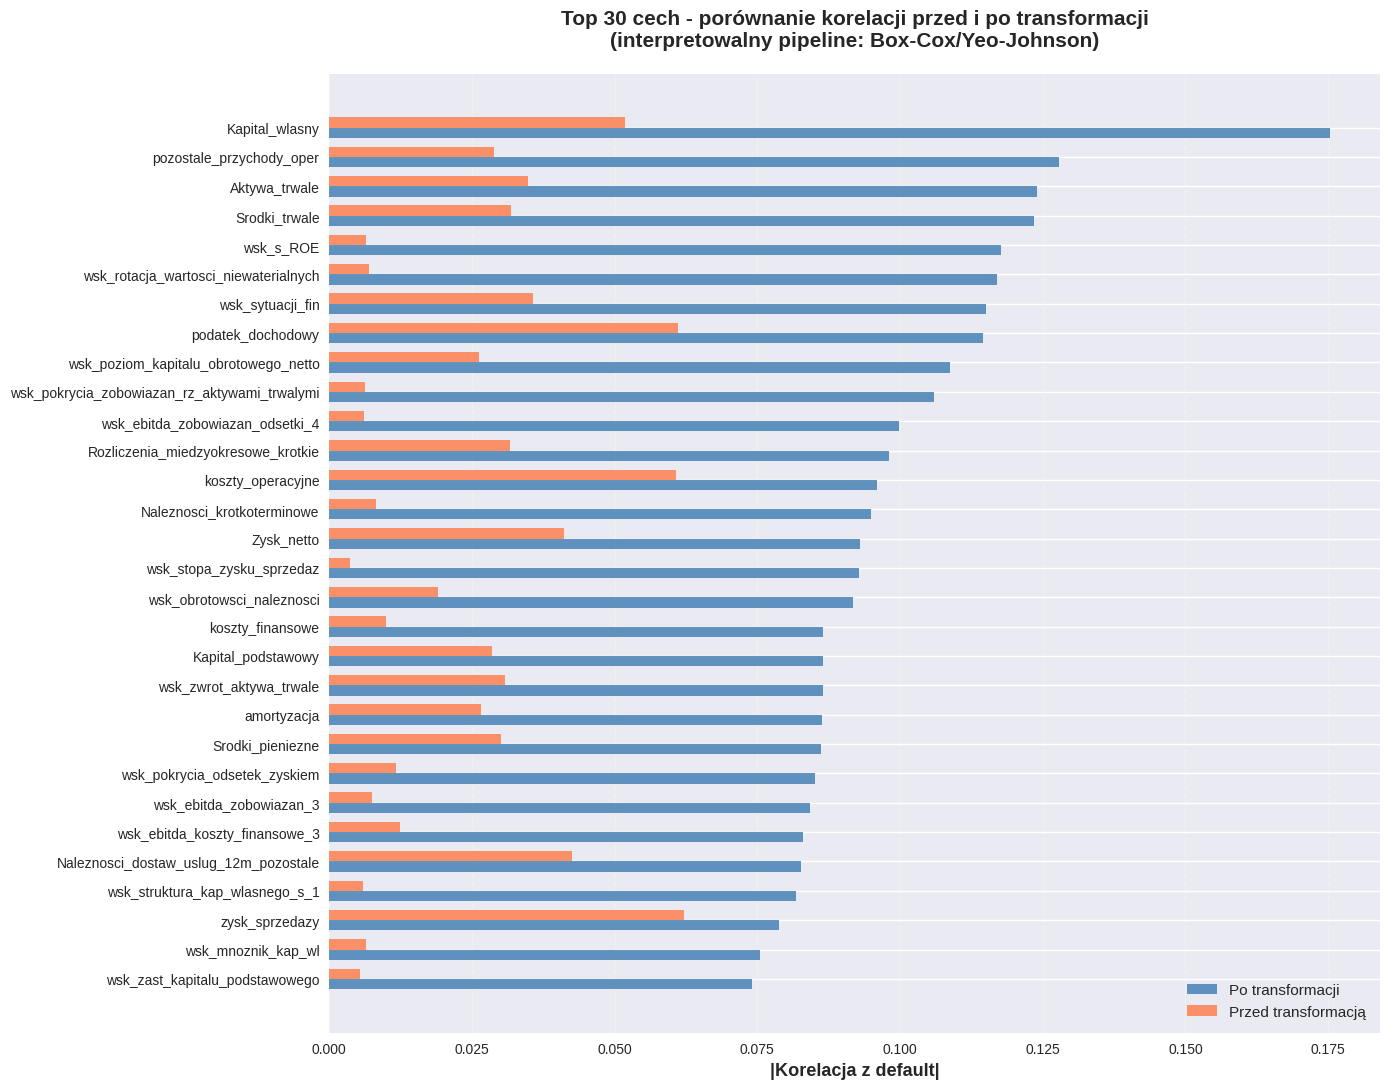


STATYSTYKI PORÓWNAWCZE (dla wspólnych cech)
Średnia |r| przed transformacją: 0.0178
Średnia |r| po transformacji:    0.0508
Poprawa korelacji:               +185.33%

Liczba cech, które się poprawiły: 91
Liczba cech, które się pogorszyły: 15


In [224]:
# Dane przed transformacją (tylko numeryczne)
X_train_before = X_train.select_dtypes(include='number')

# Korelacje
corr_before = X_train_before.corrwith(y_train).abs().sort_values(ascending=False)
corr_after = X_train_transformed.corrwith(y_train).abs().sort_values(ascending=False)

# Wspólne cechy (te które nie zostały usunięte)
common_features = list(set(corr_before.index) & set(corr_after.index))
corr_comparison = pd.DataFrame({
    'przed': corr_before[common_features],
    'po': corr_after[common_features]
}).sort_values('po', ascending=False)

# Wykres top 30
top_30_comparison = corr_comparison.head(30)

fig, ax = plt.subplots(figsize=(14, 11))
x = np.arange(len(top_30_comparison))
width = 0.35

ax.barh(x + width/2, top_30_comparison['po'], width, label='Po transformacji', color='steelblue', alpha=0.85)
ax.barh(x - width/2, top_30_comparison['przed'], width, label='Przed transformacją', color='coral', alpha=0.85)

ax.set_yticks(x)
ax.set_yticklabels(top_30_comparison.index)
ax.set_xlabel('|Korelacja z default|', fontsize=13, fontweight='bold')
ax.set_title('Top 30 cech - porównanie korelacji przed i po transformacji\n(interpretowalny pipeline: Box-Cox/Yeo-Johnson)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STATYSTYKI PORÓWNAWCZE (dla wspólnych cech)")
print("="*60)
print(f"Średnia |r| przed transformacją: {corr_comparison['przed'].mean():.4f}")
print(f"Średnia |r| po transformacji:    {corr_comparison['po'].mean():.4f}")
improvement = ((corr_comparison['po'].mean() / corr_comparison['przed'].mean() - 1) * 100)
print(f"Poprawa korelacji:               {improvement:+.2f}%")
print(f"\nLiczba cech, które się poprawiły: {(corr_comparison['po'] > corr_comparison['przed']).sum()}")
print(f"Liczba cech, które się pogorszyły: {(corr_comparison['po'] < corr_comparison['przed']).sum()}")

### Rozkład skośności przed i po transformacji

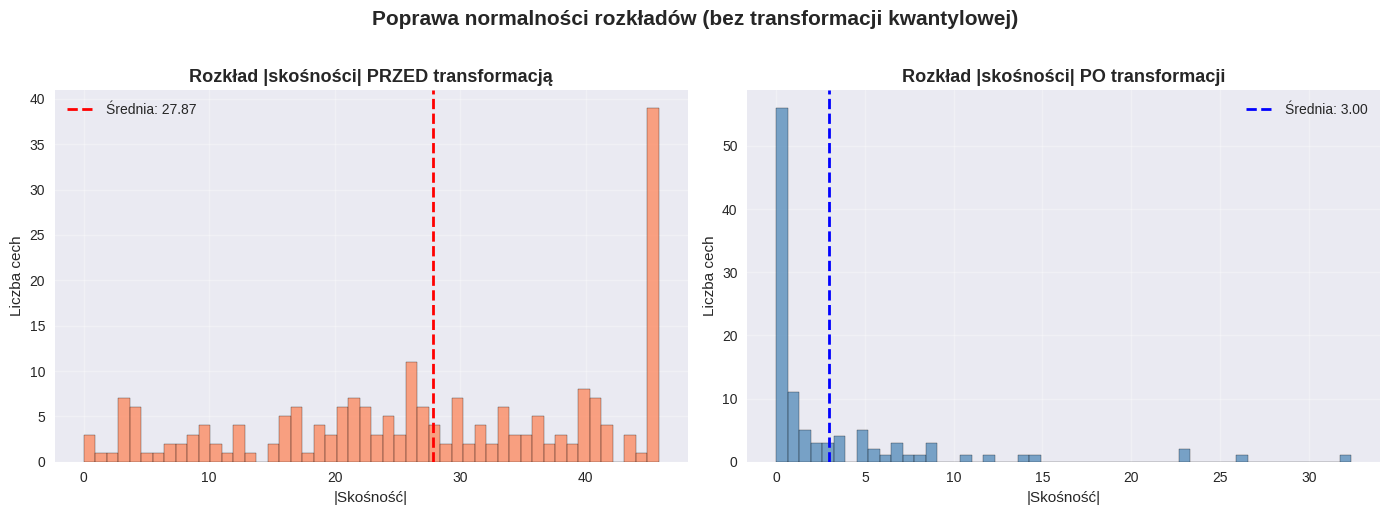


Statystyki |skośności|:
  PRZED: średnia = 27.874, mediana = 27.541, max = 45.826
  PO:    średnia = 3.002, mediana = 0.520, max = 32.381

  Redukcja średniej skośności: 89.2%


In [225]:
# Obliczenie skośności
skew_before = X_train_before.skew().abs()
skew_after = X_train_transformed.skew().abs()

# Histogram porównawczy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(skew_before, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].axvline(skew_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {skew_before.mean():.2f}')
axes[0].set_title('Rozkład |skośności| PRZED transformacją', fontsize=13, fontweight='bold')
axes[0].set_xlabel('|Skośność|')
axes[0].set_ylabel('Liczba cech')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(skew_after, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(skew_after.mean(), color='blue', linestyle='--', linewidth=2, label=f'Średnia: {skew_after.mean():.2f}')
axes[1].set_title('Rozkład |skośności| PO transformacji', fontsize=13, fontweight='bold')
axes[1].set_xlabel('|Skośność|')
axes[1].set_ylabel('Liczba cech')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Poprawa normalności rozkładów (bez transformacji kwantylowej)', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nStatystyki |skośności|:")
print(f"  PRZED: średnia = {skew_before.mean():.3f}, mediana = {skew_before.median():.3f}, max = {skew_before.max():.3f}")
print(f"  PO:    średnia = {skew_after.mean():.3f}, mediana = {skew_after.median():.3f}, max = {skew_after.max():.3f}")
print(f"\n  Redukcja średniej skośności: {(1 - skew_after.mean()/skew_before.mean())*100:.1f}%")

## Podsumowanie Preprocessing

In [226]:
final_correlations = X_train_transformed.corrwith(y_train).abs().sort_values(ascending=False)

print("="*70)
print("📊 PODSUMOWANIE PREPROCESSING")
print("="*70)

print(f"\n🔢 WYMIARY:")
print(f"  • Oryginał:         {X_train.shape}")
print(f"  • Po preprocessing: {X_train_transformed.shape}")
print(f"  • Redukcja:         {X_train.shape[1] - X_train_transformed.shape[1]} cech ({(1-X_train_transformed.shape[1]/X_train.shape[1])*100:.1f}%)")

print(f"\n🗑️  USUNIĘTE KOLUMNY:")
for category, cols in pipeline.columns_to_drop_.items():
    if category != 'all' and category != 'sparse_binary':
        print(f"  • {category:.<20} {len(cols):>3} kolumn")
print(f"  • {'Korelacje':.<20} {len(pipeline.high_corr_columns_to_drop_):>3} kolumn")

print(f"\n🔧 TRANSFORMACJE:")
method_counts = {}
# Normalne transformacje (Box-Cox, Yeo-Johnson, log1p)
for col in pipeline.final_columns_:
    if col in pipeline.transformers_:
        method = pipeline.transformers_[col].method_used_
        method_counts[method] = method_counts.get(method, 0) + 1

# Binarne transformacje
binary_count = len([col for col in pipeline.final_columns_ if col in pipeline.sparse_binary_cols_])
if binary_count > 0:
    method_counts['binary'] = binary_count

for method, count in sorted(method_counts.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(pipeline.final_columns_) * 100
    print(f"  • {method:.<20} {count:>3} cech ({pct:.1f}%)")

print(f"\n📈 JAKOŚĆ:")
print(f"  • Średnia |skośność|:  {X_train_transformed.skew().abs().mean():.4f}")
print(f"  • Max |skośność|:      {X_train_transformed.skew().abs().max():.4f}")

print(f"\n🎯 KORELACJA Z DEFAULT:")
print(f"  • |r| > 0.20:    {(final_correlations > 0.20).sum()} cech (bardzo silne)")
print(f"  • |r| > 0.15:    {(final_correlations > 0.15).sum()} cech (silne)")
print(f"  • |r| > 0.10:    {(final_correlations > 0.10).sum()} cech (umiarkowane)")
print(f"  • Najlepsza:     '{final_correlations.index[0]}' (|r| = {final_correlations.iloc[0]:.4f})")

print(f"\n✅ CECHY INTERPRETOWALNOŚCI:")
print(f"  ✓ Wszystkie transformacje są ODWRACALNE")
print(f"  ✓ Dostępna funkcja inverse_transform()")
print(f"  ✓ Zachowana monotoniczność (brak rank-based)")
print(f"  ✓ {len(pipeline.sparse_binary_cols_)} kolumn sparse jako binarne wskaźniki")
print(f"  ✓ Gotowe do SHAP, LIME, PDP, ICE")

print("\n" + "="*70)
print("✅ PIPELINE GOTOWY DO MODELOWANIA!")
print("="*70)

📊 PODSUMOWANIE PREPROCESSING

🔢 WYMIARY:
  • Oryginał:         (2100, 219)
  • Po preprocessing: (2100, 106)
  • Redukcja:         113 cech (51.6%)

🗑️  USUNIĘTE KOLUMNY:
  • missing.............  10 kolumn
  • categorical.........   2 kolumn
  • low_variance........   1 kolumn
  • constant............   1 kolumn
  • Korelacje...........  99 kolumn

🔧 TRANSFORMACJE:
  • yeo-johnson.........  67 cech (63.2%)
  • binary..............  30 cech (28.3%)
  • box-cox.............   9 cech (8.5%)

📈 JAKOŚĆ:
  • Średnia |skośność|:  3.0021
  • Max |skośność|:      32.3805

🎯 KORELACJA Z DEFAULT:
  • |r| > 0.20:    0 cech (bardzo silne)
  • |r| > 0.15:    1 cech (silne)
  • |r| > 0.10:    10 cech (umiarkowane)
  • Najlepsza:     'Kapital_wlasny' (|r| = 0.1753)

✅ CECHY INTERPRETOWALNOŚCI:
  ✓ Wszystkie transformacje są ODWRACALNE
  ✓ Dostępna funkcja inverse_transform()
  ✓ Zachowana monotoniczność (brak rank-based)
  ✓ 32 kolumn sparse jako binarne wskaźniki
  ✓ Gotowe do SHAP, LIME, PDP, ICE



# Modelowanie - Modele Interpretowalne

Trenowanie i ewaluacja poszczególnych modeli interpretowalnych.

### Model 1: Regresja Logistyczna (Full Pipeline)

Model liniowy z wysoką interpretowalnością - łatwo zrozumieć wpływ każdej cechy.

In [227]:
# Diagnostyka danych po nowym preprocessingu
print("="*70)
print("DIAGNOSTYKA DANYCH PO PREPROCESSINGU (z binarną transformacją sparse)")
print("="*70)

print(f"\n📊 X_train_transformed_new:")
print(f"  • Shape: {X_train_transformed_new.shape}")
print(f"  • Liczba NaN: {X_train_transformed_new.isna().sum().sum()}")
print(f"  • Liczba Inf: {np.isinf(X_train_transformed_new.values).sum()}")

print(f"\n📊 X_test_transformed_new:")
print(f"  • Shape: {X_test_transformed_new.shape}")
print(f"  • Liczba NaN: {X_test_transformed_new.isna().sum().sum()}")
print(f"  • Liczba Inf: {np.isinf(X_test_transformed_new.values).sum()}")

print("\n✅ DANE CZYSTE - gotowe do modelowania!")

# Pokażmy binarne kolumny
print(f"\n📋 KOLUMNY BINARNE (sparse → binary):")
print(f"  • Liczba: {len(pipeline_new.sparse_binary_cols_)}")
if len(pipeline_new.sparse_binary_cols_) > 0:
    print("\n  Top 10 kolumn binarnych:")
    for i, col in enumerate(pipeline_new.sparse_binary_cols_[:10], 1):
        # Sprawdź ile jest jedynek
        if col in X_train_transformed_new.columns:
            ones_pct = (X_train_transformed_new[col] == 1).sum() / len(X_train_transformed_new) * 100
            print(f"    {i:2d}. {col:<50} {ones_pct:5.2f}% jedynek")

print(f"\n📈 PORÓWNANIE:")
print(f"  • Pipeline poprzedni: 75 cech")
print(f"  • Pipeline z binary:  {X_train_transformed_new.shape[1]} cech (+{X_train_transformed_new.shape[1]-75})")
print(f"  • Zyskaliśmy {len(pipeline_new.sparse_binary_cols_)} binarnych wskaźników!")
print(f"    (np. 'czy firma ma kredyty?', 'czy ma dotacje?', etc.)")

DIAGNOSTYKA DANYCH PO PREPROCESSINGU (z binarną transformacją sparse)

📊 X_train_transformed_new:
  • Shape: (2100, 106)
  • Liczba NaN: 0
  • Liczba Inf: 0

📊 X_test_transformed_new:
  • Shape: (900, 106)
  • Liczba NaN: 0
  • Liczba Inf: 0

✅ DANE CZYSTE - gotowe do modelowania!

📋 KOLUMNY BINARNE (sparse → binary):
  • Liczba: 32

  Top 10 kolumn binarnych:
     1. Wartosc_firmy                                       0.52% jedynek
     2. Naleznosci_dlugoterminowe                           4.05% jedynek
     3. Rozliczenia_miedzyokresowe_dlugie                   7.90% jedynek
     4. Naleznosci_dostaw_uslug_12m_powiazane               6.90% jedynek
     5. Naleznosci_dostaw_uslug_pow12m_powiazane            0.19% jedynek
     6. Naleznosci_dostaw_uslug_12m_kapitale                1.95% jedynek
     7. Naleznosci_dostaw_uslug_pow12m_kapitale             0.10% jedynek
     8. Naleznosci_dostaw_uslug_pow12m_pozostale            1.19% jedynek
     9. Naleznosci_dostaw_uslug_pozostale_sad

In [228]:
# Trening Regresji Logistycznej
print("="*70)
print("MODEL 1: REGRESJA LOGISTYCZNA")
print("="*70)

start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_transformed, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_lr = lr_model.predict(X_test_transformed)
y_proba_lr = lr_model.predict_proba(X_test_transformed)[:, 1]

# Metryki
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {lr_accuracy:.4f}")
print(f"  • Precision: {lr_precision:.4f}")
print(f"  • Recall:    {lr_recall:.4f}")
print(f"  • F1-Score:  {lr_f1:.4f}")
print(f"  • ROC-AUC:   {lr_auc:.4f}")

# Macierz pomyłek
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_lr[0,0]}, FP={cm_lr[0,1]}")
print(f"  FN={cm_lr[1,0]}, TP={cm_lr[1,1]}")

MODEL 1: REGRESJA LOGISTYCZNA

✅ Model wytrenowany w 0.09s

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.7156
  • Precision: 0.1124
  • Recall:    0.6122
  • F1-Score:  0.1899
  • ROC-AUC:   0.7152

🎯 Macierz pomyłek:
  TN=614, FP=237
  FN=19, TP=30

✅ Model wytrenowany w 0.09s

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.7156
  • Precision: 0.1124
  • Recall:    0.6122
  • F1-Score:  0.1899
  • ROC-AUC:   0.7152

🎯 Macierz pomyłek:
  TN=614, FP=237
  FN=19, TP=30


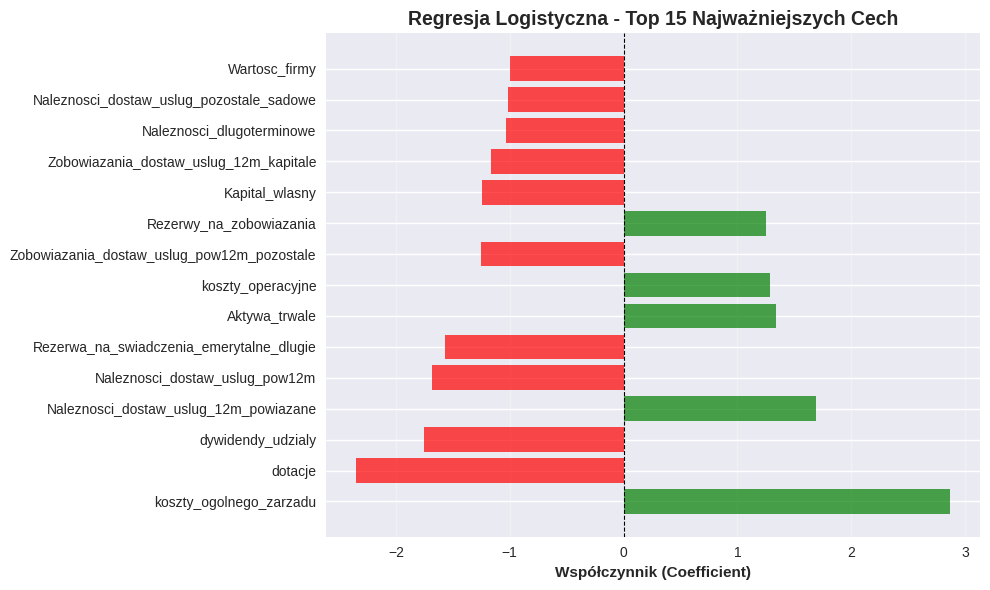


📈 Top 5 cech:
  koszty_ogolnego_zarzadu: 2.8694 ↑ zwiększa ryzyko
  dotacje: -2.3509 ↓ zmniejsza ryzyko
  dywidendy_udzialy: -1.7545 ↓ zmniejsza ryzyko
  Naleznosci_dostaw_uslug_12m_powiazane: 1.6884 ↑ zwiększa ryzyko
  Naleznosci_dostaw_uslug_pow12m: -1.6805 ↓ zmniejsza ryzyko


In [229]:
# Wizualizacja: Top 15 najważniejszych cech (współczynniki)
coef_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False).head(15)

plt.figure(figsize=(10, 6))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Współczynnik (Coefficient)', fontweight='bold')
plt.title('Regresja Logistyczna - Top 15 Najważniejszych Cech', fontweight='bold', fontsize=14)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Top 5 cech:")
for i, row in coef_df.head(5).iterrows():
    direction = "↑ zwiększa" if row['Coefficient'] > 0 else "↓ zmniejsza"
    print(f"  {row['Feature']}: {row['Coefficient']:.4f} {direction} ryzyko")

### Model 2: Drzewo Decyzyjne (Full Pipeline)

Model nieparametryczny z wizualną interpretowalnością - łatwo zrozumieć zasady decyzyjne.

In [230]:
# Trening Drzewa Decyzyjnego
print("="*70)
print("MODEL 2: DRZEWO DECYZYJNE")
print("="*70)

start_time = time.time()
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=100, min_samples_leaf=50, 
                                   random_state=42, class_weight='balanced')
dt_model.fit(X_train_transformed, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_dt = dt_model.predict(X_test_transformed)
y_proba_dt = dt_model.predict_proba(X_test_transformed)[:, 1]

# Metryki
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_proba_dt)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"   Głębokość drzewa: {dt_model.get_depth()}")
print(f"   Liczba liści: {dt_model.get_n_leaves()}")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {dt_accuracy:.4f}")
print(f"  • Precision: {dt_precision:.4f}")
print(f"  • Recall:    {dt_recall:.4f}")
print(f"  • F1-Score:  {dt_f1:.4f}")
print(f"  • ROC-AUC:   {dt_auc:.4f}")

# Macierz pomyłek
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_dt[0,0]}, FP={cm_dt[0,1]}")
print(f"  FN={cm_dt[1,0]}, TP={cm_dt[1,1]}")

MODEL 2: DRZEWO DECYZYJNE

✅ Model wytrenowany w 0.10s
   Głębokość drzewa: 5
   Liczba liści: 18

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.6400
  • Precision: 0.1014
  • Recall:    0.7143
  • F1-Score:  0.1777
  • ROC-AUC:   0.6717

🎯 Macierz pomyłek:
  TN=541, FP=310
  FN=14, TP=35


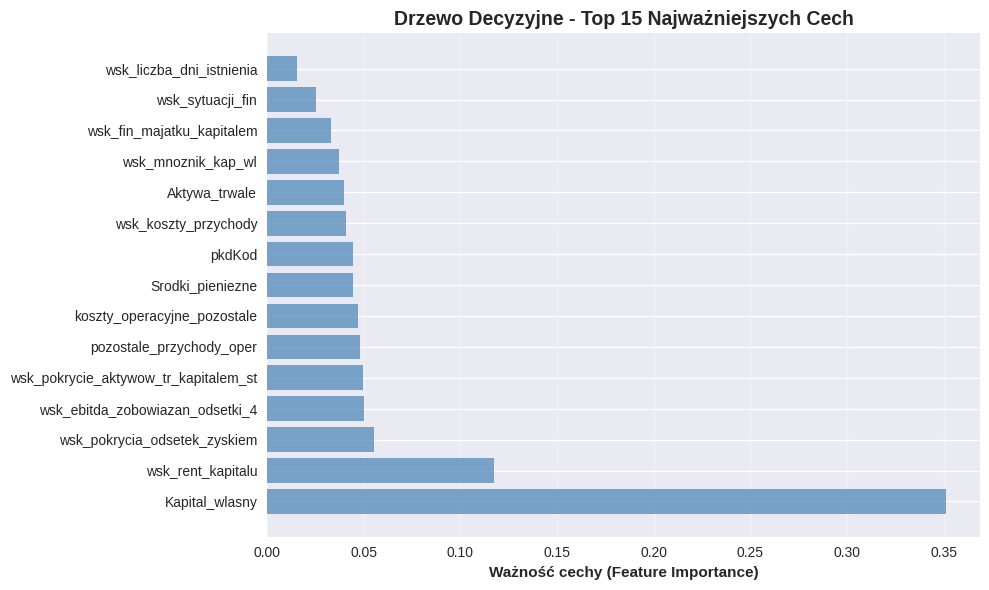


📈 Top 5 cech:
  Kapital_wlasny: 0.3512
  wsk_rent_kapitalu: 0.1175
  wsk_pokrycia_odsetek_zyskiem: 0.0555
  wsk_ebitda_zobowiazan_odsetki_4: 0.0503
  wsk_pokrycie_aktywow_tr_kapitalem_st: 0.0496


In [231]:
# Wizualizacja: Top 15 najważniejszych cech (feature importance)
feat_imp_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Ważność cechy (Feature Importance)', fontweight='bold')
plt.title('Drzewo Decyzyjne - Top 15 Najważniejszych Cech', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 Top 5 cech:")
for i, row in feat_imp_df.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

### Model 3: Naiwny Bayes (Full Pipeline)

Model probabilistyczny oparty na założeniu niezależności cech.

In [232]:
# Trening Naiwnego Klasyfikatora Bayesowskiego
print("="*70)
print("MODEL 3: NAIWNY KLASYFIKATOR BAYESOWSKI")
print("="*70)

start_time = time.time()
nb_model = GaussianNB()
nb_model.fit(X_train_transformed, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_nb = nb_model.predict(X_test_transformed)
y_proba_nb = nb_model.predict_proba(X_test_transformed)[:, 1]

# Metryki
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, y_proba_nb)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {nb_accuracy:.4f}")
print(f"  • Precision: {nb_precision:.4f}")
print(f"  • Recall:    {nb_recall:.4f}")
print(f"  • F1-Score:  {nb_f1:.4f}")
print(f"  • ROC-AUC:   {nb_auc:.4f}")

# Macierz pomyłek
cm_nb = confusion_matrix(y_test, y_pred_nb)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_nb[0,0]}, FP={cm_nb[0,1]}")
print(f"  FN={cm_nb[1,0]}, TP={cm_nb[1,1]}")

MODEL 3: NAIWNY KLASYFIKATOR BAYESOWSKI

✅ Model wytrenowany w 0.02s

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.1622
  • Precision: 0.0588
  • Recall:    0.9592
  • F1-Score:  0.1108
  • ROC-AUC:   0.5595

🎯 Macierz pomyłek:
  TN=99, FP=752
  FN=2, TP=47


### Model 4: Explainable Boosting Machine (Full Pipeline)

Zaawansowany model addytywny z pełną interpretowalnością.

In [233]:
# Trening EBM (jeśli dostępny)
if EBM_AVAILABLE:
    print("="*70)
    print("MODEL 4: EXPLAINABLE BOOSTING MACHINE (EBM)")
    print("="*70)
    
    start_time = time.time()
    ebm_model = ExplainableBoostingClassifier(random_state=42, interactions=5)
    ebm_model.fit(X_train_transformed, y_train)
    training_time = time.time() - start_time
    
    # Predykcje
    y_pred_ebm = ebm_model.predict(X_test_transformed)
    y_proba_ebm = ebm_model.predict_proba(X_test_transformed)[:, 1]
    
    # Metryki
    ebm_accuracy = accuracy_score(y_test, y_pred_ebm)
    ebm_precision = precision_score(y_test, y_pred_ebm)
    ebm_recall = recall_score(y_test, y_pred_ebm)
    ebm_f1 = f1_score(y_test, y_pred_ebm)
    ebm_auc = roc_auc_score(y_test, y_proba_ebm)
    
    print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
    print(f"\n📊 Wyniki na zbiorze testowym:")
    print(f"  • Accuracy:  {ebm_accuracy:.4f}")
    print(f"  • Precision: {ebm_precision:.4f}")
    print(f"  • Recall:    {ebm_recall:.4f}")
    print(f"  • F1-Score:  {ebm_f1:.4f}")
    print(f"  • ROC-AUC:   {ebm_auc:.4f}")
    
    # Macierz pomyłek
    cm_ebm = confusion_matrix(y_test, y_pred_ebm)
    print(f"\n🎯 Macierz pomyłek:")
    print(f"  TN={cm_ebm[0,0]}, FP={cm_ebm[0,1]}")
    print(f"  FN={cm_ebm[1,0]}, TP={cm_ebm[1,1]}")
else:
    print("⚠️  EBM nie jest dostępny - biblioteka interpret nie została zainstalowana")
    ebm_model = None

MODEL 4: EXPLAINABLE BOOSTING MACHINE (EBM)

✅ Model wytrenowany w 30.81s

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.9456
  • Precision: 0.0000
  • Recall:    0.0000
  • F1-Score:  0.0000
  • ROC-AUC:   0.7387

🎯 Macierz pomyłek:
  TN=851, FP=0
  FN=49, TP=0

✅ Model wytrenowany w 30.81s

📊 Wyniki na zbiorze testowym:
  • Accuracy:  0.9456
  • Precision: 0.0000
  • Recall:    0.0000
  • F1-Score:  0.0000
  • ROC-AUC:   0.7387

🎯 Macierz pomyłek:
  TN=851, FP=0
  FN=49, TP=0


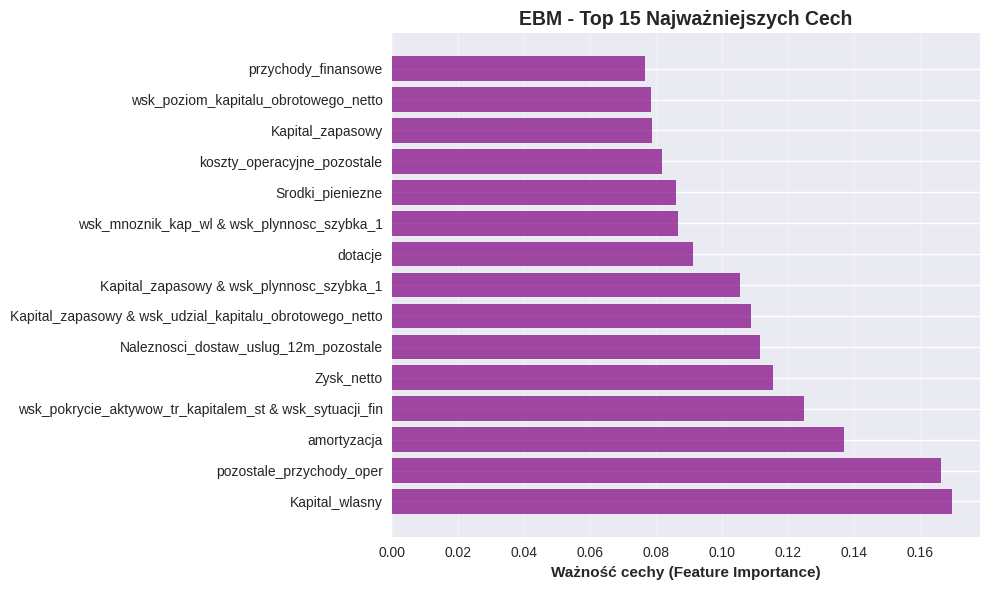


📈 Top 5 cech:
  Kapital_wlasny: 0.1697
  pozostale_przychody_oper: 0.1663
  amortyzacja: 0.1370
  wsk_pokrycie_aktywow_tr_kapitalem_st & wsk_sytuacji_fin: 0.1249
  Zysk_netto: 0.1153


In [234]:
# Wizualizacja EBM (jeśli dostępny)
if EBM_AVAILABLE and ebm_model is not None:
    # EBM używa term_importances() - zwraca również interakcje
    ebm_global = ebm_model.explain_global()
    
    # Wyciągnij nazwy cech i ich ważności
    feature_names = ebm_global.data()['names']
    importances = ebm_global.data()['scores']
    
    # Stwórz DataFrame i posortuj
    feat_imp_ebm = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_ebm['Feature'], feat_imp_ebm['Importance'], color='purple', alpha=0.7)
    plt.xlabel('Ważność cechy (Feature Importance)', fontweight='bold')
    plt.title('EBM - Top 15 Najważniejszych Cech', fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n📈 Top 5 cech:")
    for i, row in feat_imp_ebm.head(5).iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

## Porównanie Modeli

Porównanie wszystkich wytrenowanych modeli na podstawie metryk wydajności.

In [235]:
# Porównanie wyników wszystkich modeli
results = []

# Regresja Logistyczna
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': lr_accuracy,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'F1-Score': lr_f1,
    'ROC-AUC': lr_auc
})

# Drzewo Decyzyjne
results.append({
    'Model': 'Decision Tree',
    'Accuracy': dt_accuracy,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1-Score': dt_f1,
    'ROC-AUC': dt_auc
})

# Naive Bayes
results.append({
    'Model': 'Naive Bayes',
    'Accuracy': nb_accuracy,
    'Precision': nb_precision,
    'Recall': nb_recall,
    'F1-Score': nb_f1,
    'ROC-AUC': nb_auc
})

# EBM (jeśli dostępny)
if EBM_AVAILABLE and ebm_model is not None:
    results.append({
        'Model': 'EBM',
        'Accuracy': ebm_accuracy,
        'Precision': ebm_precision,
        'Recall': ebm_recall,
        'F1-Score': ebm_f1,
        'ROC-AUC': ebm_auc
    })

# Tabela wyników
results_df = pd.DataFrame(results)
print("="*80)
print("PORÓWNANIE WSZYSTKICH MODELI")
print("="*80)
print(results_df.to_string(index=False))
print("\n")

# Najlepszy model dla każdej metryki
print("🏆 Najlepsze modele według metryk:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"  • {metric:12s}: {best_model:20s} ({best_value:.4f})")

PORÓWNANIE WSZYSTKICH MODELI
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.715556   0.112360 0.612245  0.189873 0.715221
      Decision Tree  0.640000   0.101449 0.714286  0.177665 0.671719
        Naive Bayes  0.162222   0.058824 0.959184  0.110849 0.559534
                EBM  0.945556   0.000000 0.000000  0.000000 0.738699


🏆 Najlepsze modele według metryk:
  • Accuracy    : EBM                  (0.9456)
  • Precision   : Logistic Regression  (0.1124)
  • Recall      : Naive Bayes          (0.9592)
  • F1-Score    : Logistic Regression  (0.1899)
  • ROC-AUC     : EBM                  (0.7387)


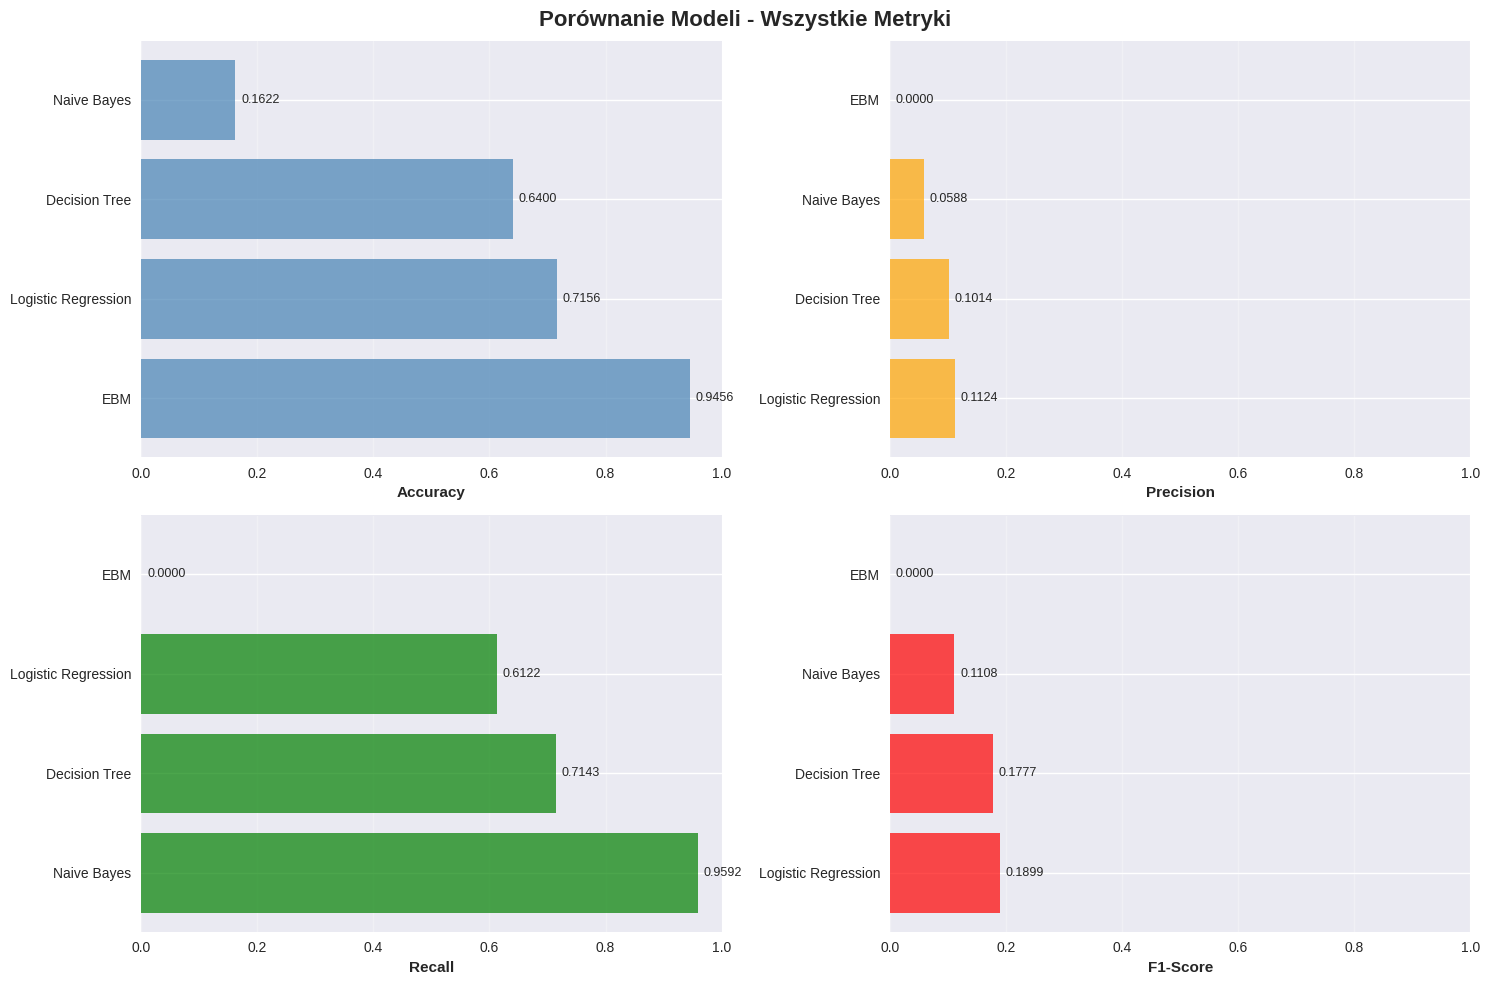

In [236]:
# Wizualizacja porównania modeli
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Porównanie Modeli - Wszystkie Metryki', fontweight='bold', fontsize=16)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'orange', 'green', 'red']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics_to_plot)):
    data = results_df.sort_values(metric, ascending=False)
    ax.barh(data['Model'], data[metric], color=colors[idx], alpha=0.7)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(axis='x', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

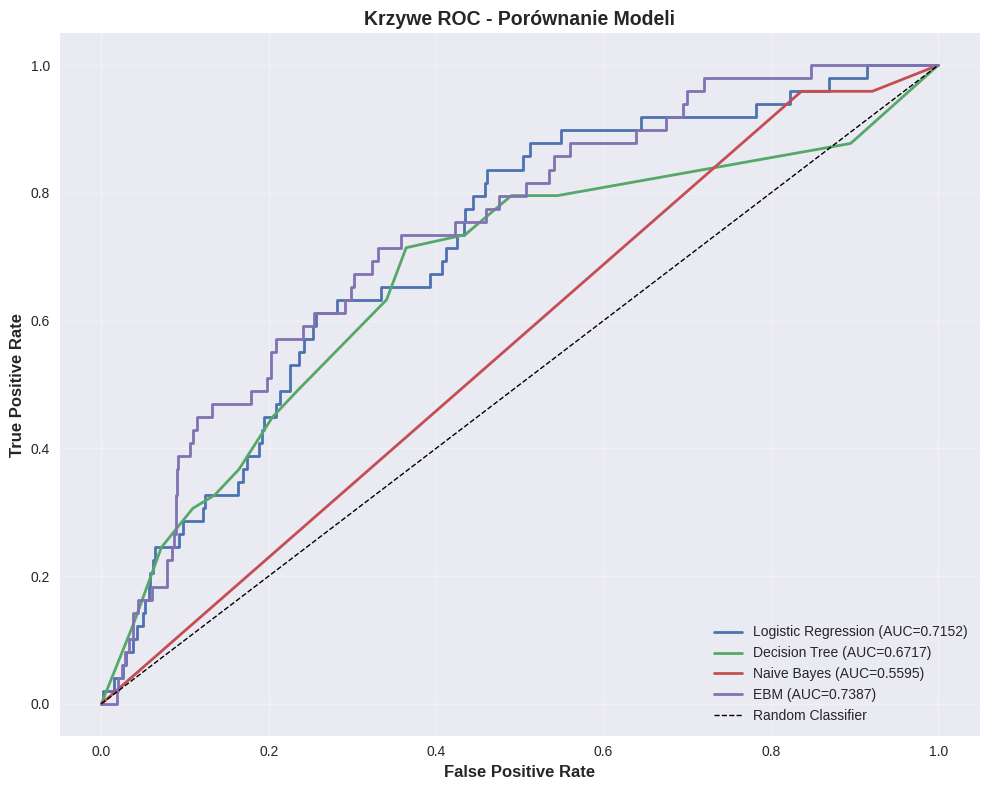

In [237]:
# Krzywe ROC dla wszystkich modeli
plt.figure(figsize=(10, 8))

# Regresja Logistyczna
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_auc:.4f})', linewidth=2)

# Drzewo Decyzyjne
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_auc:.4f})', linewidth=2)

# Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={nb_auc:.4f})', linewidth=2)

# EBM (jeśli dostępny)
if EBM_AVAILABLE and ebm_model is not None:
    fpr_ebm, tpr_ebm, _ = roc_curve(y_test, y_proba_ebm)
    plt.plot(fpr_ebm, tpr_ebm, label=f'EBM (AUC={ebm_auc:.4f})', linewidth=2)

# Linia losowa
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('Krzywe ROC - Porównanie Modeli', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [238]:
# Wszystkie binarne kolumny - pełna lista
print("WSZYSTKIE 32 BINARNE KOLUMNY:")
print("="*80)
for i, col in enumerate(pipeline_new.sparse_binary_cols_, 1):
    if col in X_train_transformed_new.columns:
        ones_pct = (X_train_transformed_new[col] == 1).sum() / len(X_train_transformed_new) * 100
        print(f"{i:2d}. {col:<55} {ones_pct:5.2f}% firm ma tę cechę")
    else:
        print(f"{i:2d}. {col:<55} [usunięta przez korelację]")

WSZYSTKIE 32 BINARNE KOLUMNY:
 1. Wartosc_firmy                                            0.52% firm ma tę cechę
 2. Naleznosci_dlugoterminowe                                4.05% firm ma tę cechę
 3. Rozliczenia_miedzyokresowe_dlugie                        7.90% firm ma tę cechę
 4. Naleznosci_dostaw_uslug_12m_powiazane                    6.90% firm ma tę cechę
 5. Naleznosci_dostaw_uslug_pow12m_powiazane                 0.19% firm ma tę cechę
 6. Naleznosci_dostaw_uslug_12m_kapitale                     1.95% firm ma tę cechę
 7. Naleznosci_dostaw_uslug_pow12m_kapitale                  0.10% firm ma tę cechę
 8. Naleznosci_dostaw_uslug_pow12m_pozostale                 1.19% firm ma tę cechę
 9. Naleznosci_dostaw_uslug_pozostale_sadowe                 1.76% firm ma tę cechę
10. Rezerwy_na_zobowiazania                                  8.62% firm ma tę cechę
11. Rezerwa_z_tytulu_odroczonego_podatku_dochodowego         2.90% firm ma tę cechę
12. Rezerwa_na_swiadczenia_emerytalne         

In [239]:
# Zastąpmy stary pipeline nowym (z binarną transformacją)
pipeline = pipeline_new
X_train_transformed = X_train_transformed_new
X_test_transformed = X_test_transformed_new

print("✅ Zaktualizowano zmienne globalne:")
print(f"  • pipeline: teraz z keep_sparse_as_binary=True")
print(f"  • X_train_transformed: {X_train_transformed.shape}")
print(f"  • X_test_transformed: {X_test_transformed.shape}")
print(f"\n🎉 GOTOWE do trenowania modeli!")

✅ Zaktualizowano zmienne globalne:
  • pipeline: teraz z keep_sparse_as_binary=True
  • X_train_transformed: (2100, 106)
  • X_test_transformed: (900, 106)

🎉 GOTOWE do trenowania modeli!


---

# CZĘŚĆ 2: MINIMALNY PIPELINE (BEZ TRANSFORMACJI)

W tej sekcji testujemy alternatywne podejście - minimal pipeline, który wykonuje tylko:
- Winsoryzację outlierów
- Usunięcie kolumn skorelowanych
- Standaryzację (bez transformacji Box-Cox/Yeo-Johnson)

Celem jest sprawdzenie, czy skomplikowane transformacje rzeczywiście poprawiają wydajność modeli.

## ⚠️ WAŻNE - KOLEJNOŚĆ URUCHAMIANIA:
**Przewiń w dół do komórki "Zastosowanie Minimalnego Pipeline" i uruchom ją NAJPIERW!**
Następnie wróć tutaj i uruchamiaj komórki treningu modeli od góry do dołu.

In [240]:
# Szczegółowa analiza różnic między pipeline'ami

# Sprawdź czy zmienne z minimalnego pipeline istnieją
try:
    lr_minimal_accuracy
    minimal_pipeline_ready = True
except NameError:
    minimal_pipeline_ready = False
    print("⚠️  Minimal pipeline nie został jeszcze uruchomiony!")
    print("   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.")

if minimal_pipeline_ready:
    print("="*80)
    print("SZCZEGÓŁOWA ANALIZA RÓŻNIC")
    print("="*80)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    models_list = ['Logistic Regression', 'Decision Tree', 'Naive Bayes']
    
    if EBM_AVAILABLE and ebm_model is not None and ebm_model_minimal is not None:
        models_list.append('EBM')
    
    for model_name in models_list:
        print(f"\n{'='*80}")
        print(f"📊 {model_name}")
        print(f"{'='*80}")
        
        # Wyciągnij metryki dla danego modelu
        full_metrics = comparison_df[(comparison_df['Pipeline'] == 'Full (transformations)') & 
                                      (comparison_df['Model'] == model_name)].iloc[0]
        minimal_metrics = comparison_df[(comparison_df['Pipeline'] == 'Minimal (no transformations)') & 
                                         (comparison_df['Model'] == model_name)].iloc[0]
        
        print(f"\n{'Metryka':<15} {'Full':<10} {'Minimal':<10} {'Różnica':<10} {'Winner':<10}")
        print("-" * 70)
        
        for metric in metrics:
            full_val = full_metrics[metric]
            minimal_val = minimal_metrics[metric]
            diff = full_val - minimal_val
            winner = 'Full' if full_val > minimal_val else ('Minimal' if minimal_val > full_val else 'Tie')
            
            print(f"{metric:<15} {full_val:<10.4f} {minimal_val:<10.4f} {diff:+10.4f} {winner:<10}")
    
    print("\n" + "="*80)
    print("✅ ANALIZA ZAKOŃCZONA")
    print("="*80)
        

⚠️  Minimal pipeline nie został jeszcze uruchomiony!
   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.


---

# CZĘŚĆ 3: PORÓWNANIE PIPELINE'ÓW

W tej sekcji porównujemy wyniki modeli trenowanych na:
- **Full Pipeline**: z transformacjami Box-Cox/Yeo-Johnson (106 cech)
- **Minimal Pipeline**: bez transformacji, tylko winsoryzacja i standaryzacja

Komórki poniżej wymagają, aby modele z minimalnego pipeline'u były już wytrenowane (przewiń w dół do sekcji "Minimalny Pipeline" i uruchom komórki 62-73).

### Wykres słupkowy: ROC-AUC

In [241]:
# Wykres słupkowy porównujący ROC-AUC

# Sprawdź czy zmienne z minimalnego pipeline istnieją
try:
    lr_minimal_auc
    minimal_pipeline_ready = True
except NameError:
    minimal_pipeline_ready = False
    print("⚠️  Minimal pipeline nie został jeszcze uruchomiony!")
    print("   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.")

if not minimal_pipeline_ready:
    raise SystemExit("Zatrzymano - brak danych z minimalnego pipeline")

fig, ax = plt.subplots(figsize=(12, 6))

# Przygotowanie danych
models = ['Logistic Regression', 'Decision Tree', 'Naive Bayes']
full_aucs = [lr_auc, dt_auc, nb_auc]
minimal_aucs = [lr_minimal_auc, dt_minimal_auc, nb_minimal_auc]

if EBM_AVAILABLE and ebm_model is not None and ebm_model_minimal is not None:
    models.append('EBM')
    full_aucs.append(ebm_auc)
    minimal_aucs.append(ebm_minimal_auc)

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, full_aucs, width, label='Full Pipeline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, minimal_aucs, width, label='Minimal Pipeline', color='coral', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('ROC-AUC', fontweight='bold', fontsize=12)
ax.set_title('Porównanie ROC-AUC: Full vs Minimal Pipeline', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.5, 1.0])

# Dodaj wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Statystyki porównawcze
print("\n" + "="*70)
print("📊 PODSUMOWANIE PORÓWNANIA")
print("="*70)
print(f"\n🔢 Liczba cech:")
print(f"  • Full Pipeline:    {X_train_transformed.shape[1]} cech")
print(f"  • Minimal Pipeline: {X_train_minimal.shape[1]} cech")

avg_full = np.mean(full_aucs)
avg_minimal = np.mean(minimal_aucs)

print(f"\n📈 Średnie ROC-AUC:")
print(f"  • Full Pipeline:    {avg_full:.4f}")
print(f"  • Minimal Pipeline: {avg_minimal:.4f}")
print(f"  • Różnica:          {avg_full - avg_minimal:+.4f}")

if avg_full > avg_minimal:
    improvement = ((avg_full / avg_minimal - 1) * 100)
    print(f"\n✅ Full Pipeline jest lepszy o {improvement:.2f}%")
else:
    improvement = ((avg_minimal / avg_full - 1) * 100)
    print(f"\n✅ Minimal Pipeline jest lepszy o {improvement:.2f}%")


⚠️  Minimal pipeline nie został jeszcze uruchomiony!
   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.


SystemExit: Zatrzymano - brak danych z minimalnego pipeline

In [242]:
# Wizualizacja porównania ROC-AUC dla obu pipeline'ów

# Sprawdź czy zmienne z minimalnego pipeline istnieją
try:
    y_proba_lr_minimal
    minimal_pipeline_ready = True
except NameError:
    minimal_pipeline_ready = False
    print("⚠️  Minimal pipeline nie został jeszcze uruchomiony!")
    print("   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.")

if not minimal_pipeline_ready:
    raise SystemExit("Zatrzymano - brak danych z minimalnego pipeline")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pipeline 1: Full (z transformacjami)
ax1 = axes[0]
ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
ax1.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_auc:.4f})', linewidth=2)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
ax1.plot(fpr_dt, tpr_dt, label=f'DT (AUC={dt_auc:.4f})', linewidth=2)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
ax1.plot(fpr_nb, tpr_nb, label=f'NB (AUC={nb_auc:.4f})', linewidth=2)

if EBM_AVAILABLE and ebm_model is not None:
    fpr_ebm, tpr_ebm, _ = roc_curve(y_test, y_proba_ebm)
    ax1.plot(fpr_ebm, tpr_ebm, label=f'EBM (AUC={ebm_auc:.4f})', linewidth=2)

ax1.set_xlabel('False Positive Rate', fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontweight='bold')
ax1.set_title('Full Pipeline (with transformations)', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Pipeline 2: Minimal (bez transformacji)
ax2 = axes[1]
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

fpr_lr_min, tpr_lr_min, _ = roc_curve(y_test, y_proba_lr_minimal)
ax2.plot(fpr_lr_min, tpr_lr_min, label=f'LR (AUC={lr_minimal_auc:.4f})', linewidth=2)

fpr_dt_min, tpr_dt_min, _ = roc_curve(y_test, y_proba_dt_minimal)
ax2.plot(fpr_dt_min, tpr_dt_min, label=f'DT (AUC={dt_minimal_auc:.4f})', linewidth=2)

fpr_nb_min, tpr_nb_min, _ = roc_curve(y_test, y_proba_nb_minimal)
ax2.plot(fpr_nb_min, tpr_nb_min, label=f'NB (AUC={nb_minimal_auc:.4f})', linewidth=2)


if EBM_AVAILABLE and ebm_model_minimal is not None:plt.show()

    fpr_ebm_min, tpr_ebm_min, _ = roc_curve(y_test, y_proba_ebm_minimal)plt.tight_layout()

    ax2.plot(fpr_ebm_min, tpr_ebm_min, label=f'EBM (AUC={ebm_minimal_auc:.4f})', linewidth=2)plt.suptitle('Krzywe ROC - Porównanie Pipeline\'ów', fontweight='bold', fontsize=16, y=1.02)



ax2.set_xlabel('False Positive Rate', fontweight='bold')ax2.grid(alpha=0.3)

ax2.set_ylabel('True Positive Rate', fontweight='bold')ax2.legend(loc='lower right')
ax2.set_title('Minimal Pipeline (no transformations)', fontweight='bold', fontsize=14)

IndentationError: unexpected indent (862749432.py, line 56)

### Krzywe ROC - porównanie pipeline'ów

In [243]:
# Porównanie wszystkich modeli z obu pipeline'ów

# Sprawdź czy zmienne z minimalnego pipeline istnieją
try:
    lr_minimal_accuracy
    minimal_pipeline_ready = True
except NameError:
    minimal_pipeline_ready = False
    print("⚠️  Minimal pipeline nie został jeszcze uruchomiony!")
    print("   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.")
    print("   (przewiń w dół do sekcji 'Zastosowanie Minimalnego Pipeline')")

if not minimal_pipeline_ready:
    # Przerwij wykonanie tej komórki
    raise SystemExit("Zatrzymano - brak danych z minimalnego pipeline")

comparison_results = []

# Modele z pełnym pipeline (z transformacjami)
comparison_results.append({
    'Pipeline': 'Full (transformations)',
    'Model': 'Logistic Regression',
    'Accuracy': lr_accuracy,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'F1-Score': lr_f1,
    'ROC-AUC': lr_auc
})

comparison_results.append({
    'Pipeline': 'Full (transformations)',
    'Model': 'Decision Tree',
    'Accuracy': dt_accuracy,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1-Score': dt_f1,
    'ROC-AUC': dt_auc
})

comparison_results.append({
    'Pipeline': 'Full (transformations)',
    'Model': 'Naive Bayes',
    'Accuracy': nb_accuracy,
    'Precision': nb_precision,
    'Recall': nb_recall,
    'F1-Score': nb_f1,
    'ROC-AUC': nb_auc
})

if EBM_AVAILABLE and ebm_model is not None:
    comparison_results.append({
        'Pipeline': 'Full (transformations)',
        'Model': 'EBM',
        'Accuracy': ebm_accuracy,
        'Precision': ebm_precision,
        'Recall': ebm_recall,
        'F1-Score': ebm_f1,
        'ROC-AUC': ebm_auc
    })

# Modele z minimalnym pipeline (bez transformacji)
comparison_results.append({
    'Pipeline': 'Minimal (no transformations)',
    'Model': 'Logistic Regression',
    'Accuracy': lr_minimal_accuracy,
    'Precision': lr_minimal_precision,
    'Recall': lr_minimal_recall,
    'F1-Score': lr_minimal_f1,
    'ROC-AUC': lr_minimal_auc
})

comparison_results.append({
    'Pipeline': 'Minimal (no transformations)',
    'Model': 'Decision Tree',
    'Accuracy': dt_minimal_accuracy,
    'Precision': dt_minimal_precision,
    'Recall': dt_minimal_recall,
    'F1-Score': dt_minimal_f1,
    'ROC-AUC': dt_minimal_auc
})

comparison_results.append({
    'Pipeline': 'Minimal (no transformations)',
    'Model': 'Naive Bayes',
    'Accuracy': nb_minimal_accuracy,
    'Precision': nb_minimal_precision,
    'Recall': nb_minimal_recall,
    'F1-Score': nb_minimal_f1,
    'ROC-AUC': nb_minimal_auc
})

if EBM_AVAILABLE and ebm_model_minimal is not None:
    comparison_results.append({
        'Pipeline': 'Minimal (no transformations)',
        'Model': 'EBM',
        'Accuracy': ebm_minimal_accuracy,
        'Precision': ebm_minimal_precision,
        'Recall': ebm_minimal_recall,
        'F1-Score': ebm_minimal_f1,
        'ROC-AUC': ebm_minimal_auc
    })

# Tabela wyników
comparison_df = pd.DataFrame(comparison_results)

print("="*100)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL PIPELINE")
print("="*100)
print("\n")
print(comparison_df.to_string(index=False))

⚠️  Minimal pipeline nie został jeszcze uruchomiony!
   Uruchom najpierw komórki z trenowaniem modeli na minimalnym pipeline.
   (przewiń w dół do sekcji 'Zastosowanie Minimalnego Pipeline')


SystemExit: Zatrzymano - brak danych z minimalnego pipeline

### Tabela porównawcza metryk

In [ ]:
# Trening EBM na danych minimalnych (jeśli dostępny)

# Sprawdź czy dane zostały przygotowane
try:
    X_train_minimal
except NameError:
    raise RuntimeError("❌ BŁĄD: X_train_minimal nie istnieje!\n"
                       "Przewiń w dół do komórki 'Zastosowanie Minimalnego Pipeline' i uruchom ją najpierw!")

if EBM_AVAILABLE:
    print("="*70)
    print("MODEL 4: EBM (MINIMAL PIPELINE)")
    print("="*70)
    
    start_time = time.time()
    ebm_model_minimal = ExplainableBoostingClassifier(random_state=42, interactions=5)
    ebm_model_minimal.fit(X_train_minimal, y_train)
    training_time = time.time() - start_time
    
    # Predykcje
    y_pred_ebm_minimal = ebm_model_minimal.predict(X_test_minimal)
    y_proba_ebm_minimal = ebm_model_minimal.predict_proba(X_test_minimal)[:, 1]
    
    # Metryki
    ebm_minimal_accuracy = accuracy_score(y_test, y_pred_ebm_minimal)
    ebm_minimal_precision = precision_score(y_test, y_pred_ebm_minimal)
    ebm_minimal_recall = recall_score(y_test, y_pred_ebm_minimal)
    ebm_minimal_f1 = f1_score(y_test, y_pred_ebm_minimal)
    ebm_minimal_auc = roc_auc_score(y_test, y_proba_ebm_minimal)
    
    print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
    print(f"\n📊 Wyniki na zbiorze testowym:")
    print(f"  • Accuracy:  {ebm_minimal_accuracy:.4f}")
    print(f"  • Precision: {ebm_minimal_precision:.4f}")
    print(f"  • Recall:    {ebm_minimal_recall:.4f}")
    print(f"  • F1-Score:  {ebm_minimal_f1:.4f}")
    print(f"  • ROC-AUC:   {ebm_minimal_auc:.4f}")
    
    # Macierz pomyłek
    cm_ebm_minimal = confusion_matrix(y_test, y_pred_ebm_minimal)
    print(f"\n🎯 Macierz pomyłek:")
    print(f"  TN={cm_ebm_minimal[0,0]}, FP={cm_ebm_minimal[0,1]}")
    print(f"  FN={cm_ebm_minimal[1,0]}, TP={cm_ebm_minimal[1,1]}")
else:
    print("⚠️  EBM nie jest dostępny")
    ebm_model_minimal = None

MODEL 4: EBM (MINIMAL PIPELINE)


NameError: name 'X_train_minimal' is not defined

### Model 4: EBM (Minimal Pipeline)

In [ ]:
# Trening Naiwnego Bayesa na danych minimalnych

# Sprawdź czy dane zostały przygotowane
try:
    X_train_minimal
except NameError:
    raise RuntimeError("❌ BŁĄD: X_train_minimal nie istnieje!\n"
                       "Przewiń w dół do komórki 'Zastosowanie Minimalnego Pipeline' i uruchom ją najpierw!")

print("="*70)
print("MODEL 3: NAIWNY BAYES (MINIMAL PIPELINE)")
print("="*70)

start_time = time.time()
nb_model_minimal = GaussianNB()
nb_model_minimal.fit(X_train_minimal, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_nb_minimal = nb_model_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_model_minimal.predict_proba(X_test_minimal)[:, 1]

# Metryki
nb_minimal_accuracy = accuracy_score(y_test, y_pred_nb_minimal)
nb_minimal_precision = precision_score(y_test, y_pred_nb_minimal)
nb_minimal_recall = recall_score(y_test, y_pred_nb_minimal)
nb_minimal_f1 = f1_score(y_test, y_pred_nb_minimal)
nb_minimal_auc = roc_auc_score(y_test, y_proba_nb_minimal)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {nb_minimal_accuracy:.4f}")
print(f"  • Precision: {nb_minimal_precision:.4f}")
print(f"  • Recall:    {nb_minimal_recall:.4f}")
print(f"  • F1-Score:  {nb_minimal_f1:.4f}")
print(f"  • ROC-AUC:   {nb_minimal_auc:.4f}")

# Macierz pomyłek
cm_nb_minimal = confusion_matrix(y_test, y_pred_nb_minimal)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_nb_minimal[0,0]}, FP={cm_nb_minimal[0,1]}")
print(f"  FN={cm_nb_minimal[1,0]}, TP={cm_nb_minimal[1,1]}")

MODEL 3: NAIVE BAYES (MINIMAL PIPELINE)


NameError: name 'X_train_minimal' is not defined

### Model 3: Naiwny Bayes (Minimal Pipeline)

In [ ]:
# Trening Drzewa Decyzyjnego na danych minimalnych

# Sprawdź czy dane zostały przygotowane
try:
    X_train_minimal
except NameError:
    raise RuntimeError("❌ BŁĄD: X_train_minimal nie istnieje!\n"
                       "Przewiń w dół do komórki 'Zastosowanie Minimalnego Pipeline' i uruchom ją najpierw!")

print("="*70)
print("MODEL 2: DRZEWO DECYZYJNE (MINIMAL PIPELINE)")
print("="*70)

start_time = time.time()
dt_model_minimal = DecisionTreeClassifier(max_depth=5, min_samples_split=100, min_samples_leaf=50, 
                                          random_state=42, class_weight='balanced')
dt_model_minimal.fit(X_train_minimal, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_dt_minimal = dt_model_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_model_minimal.predict_proba(X_test_minimal)[:, 1]

# Metryki
dt_minimal_accuracy = accuracy_score(y_test, y_pred_dt_minimal)
dt_minimal_precision = precision_score(y_test, y_pred_dt_minimal)
dt_minimal_recall = recall_score(y_test, y_pred_dt_minimal)
dt_minimal_f1 = f1_score(y_test, y_pred_dt_minimal)
dt_minimal_auc = roc_auc_score(y_test, y_proba_dt_minimal)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"   Głębokość drzewa: {dt_model_minimal.get_depth()}")
print(f"   Liczba liści: {dt_model_minimal.get_n_leaves()}")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {dt_minimal_accuracy:.4f}")
print(f"  • Precision: {dt_minimal_precision:.4f}")
print(f"  • Recall:    {dt_minimal_recall:.4f}")
print(f"  • F1-Score:  {dt_minimal_f1:.4f}")
print(f"  • ROC-AUC:   {dt_minimal_auc:.4f}")

# Macierz pomyłek
cm_dt_minimal = confusion_matrix(y_test, y_pred_dt_minimal)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_dt_minimal[0,0]}, FP={cm_dt_minimal[0,1]}")
print(f"  FN={cm_dt_minimal[1,0]}, TP={cm_dt_minimal[1,1]}")

MODEL 2: DRZEWO DECYZYJNE (MINIMAL PIPELINE)


NameError: name 'X_train_minimal' is not defined

### Model 2: Drzewo Decyzyjne (Minimal Pipeline)

In [ ]:
# Trening Regresji Logistycznej na danych minimalnych

# Sprawdź czy dane zostały przygotowane
try:
    X_train_minimal
except NameError:
    raise RuntimeError("❌ BŁĄD: X_train_minimal nie istnieje!\n"
                       "Przewiń w dół do komórki 'Zastosowanie Minimalnego Pipeline' i uruchom ją najpierw!")

print("="*70)
print("MODEL 1: REGRESJA LOGISTYCZNA (MINIMAL PIPELINE)")
print("="*70)

start_time = time.time()
lr_model_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model_minimal.fit(X_train_minimal, y_train)
training_time = time.time() - start_time

# Predykcje
y_pred_lr_minimal = lr_model_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_model_minimal.predict_proba(X_test_minimal)[:, 1]

# Metryki
lr_minimal_accuracy = accuracy_score(y_test, y_pred_lr_minimal)
lr_minimal_precision = precision_score(y_test, y_pred_lr_minimal)
lr_minimal_recall = recall_score(y_test, y_pred_lr_minimal)
lr_minimal_f1 = f1_score(y_test, y_pred_lr_minimal)
lr_minimal_auc = roc_auc_score(y_test, y_proba_lr_minimal)

print(f"\n✅ Model wytrenowany w {training_time:.2f}s")
print(f"\n📊 Wyniki na zbiorze testowym:")
print(f"  • Accuracy:  {lr_minimal_accuracy:.4f}")
print(f"  • Precision: {lr_minimal_precision:.4f}")
print(f"  • Recall:    {lr_minimal_recall:.4f}")
print(f"  • F1-Score:  {lr_minimal_f1:.4f}")
print(f"  • ROC-AUC:   {lr_minimal_auc:.4f}")

# Macierz pomyłek
cm_lr_minimal = confusion_matrix(y_test, y_pred_lr_minimal)
print(f"\n🎯 Macierz pomyłek:")
print(f"  TN={cm_lr_minimal[0,0]}, FP={cm_lr_minimal[0,1]}")
print(f"  FN={cm_lr_minimal[1,0]}, TP={cm_lr_minimal[1,1]}")

### Model 1: Regresja Logistyczna (Minimal Pipeline)

In [ ]:
# Diagnostyka danych po minimalnym preprocessingu

# Sprawdź czy dane zostały przygotowane
try:
    X_train_minimal
except NameError:
    raise RuntimeError("❌ BŁĄD: X_train_minimal nie istnieje!\n"
                       "Przewiń w dół do komórki 'Zastosowanie Minimalnego Pipeline' i uruchom ją najpierw!")

print("="*70)
print("DIAGNOSTYKA DANYCH - MINIMAL PIPELINE")
print("="*70)

print(f"\n📊 X_train_minimal:")
print(f"  • Shape: {X_train_minimal.shape}")
print(f"  • Liczba NaN: {X_train_minimal.isna().sum().sum()}")
print(f"  • Liczba Inf: {np.isinf(X_train_minimal.values).sum()}")
print(f"  • Średnia |skośność|: {X_train_minimal.skew().abs().mean():.4f}")

print(f"\n📊 X_test_minimal:")
print(f"  • Shape: {X_test_minimal.shape}")
print(f"  • Liczba NaN: {X_test_minimal.isna().sum().sum()}")
print(f"  • Liczba Inf: {np.isinf(X_test_minimal.values).sum()}")

### Diagnostyka danych minimalnego pipeline

In [ ]:
# Inicjalizacja i dopasowanie minimalnego pipeline
pipeline_minimal = MinimalPreprocessingPipeline(correlation_threshold=0.80, standardize=True)

# Dopasowanie i transformacja
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n📊 Wymiary po transformacji minimalnej:")
print(f"  • X_train: {X_train_minimal.shape}")
print(f"  • X_test: {X_test_minimal.shape}")

### Zastosowanie Minimalnego Pipeline

## Podsumowanie

Ten notebook porównuje dwie strategie preprocessingu dla modeli interpretowalnych:
1. **Full Pipeline** - pełne transformacje statystyczne
2. **Minimal Pipeline** - minimalne przekształcenia

Aby wykonać pełne porównanie, uruchom komórki w kolejności (od góry do dołu).